# <b> Classifier Models for Identifying Bank Fraud </b> 


This notebook contains end-to-end code for building classifier models to detect bank fraud, including data preprocessing, feature engineering, hyperparameter tuning, testing and evaluation. 

# 0. Import Packages and Data

## 0.0 Core Packages

In [1]:
import pandas as pd
import numpy as np

import altair as alt 
import seaborn as sns 
from matplotlib import pyplot as plt

import sklearn  
import imblearn 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 0.1 Download and Extract Data from GDrive

In [2]:
import requests 
import os 
import zipfile 

def download_and_extract(file_id, file_name): 
    if os.path.exists(file_name): 
        print(f"File '{file_name}' already exists. Skipping download.") 
        return 
    
    # Google Drive URL for file download 
    gdrive_url = "https://drive.google.com/uc?export=download" 
    session = requests.Session() 

    # Fetch file with session to handle potential redirects 
    response = session.get(
        gdrive_url, 
        params={'id': file_id}, 
        stream=True 
    )
    response.raise_for_status() # ensure download correctly initialized 

    # Handling Google Drive confirmation token if required 
    if "confirm" in response.text: 
        confirm_token = get_confirm_token(response) 
        if confirm_token: 
            response = session.get(
                gdrive_url, 
                params={'id': file_id, 'confirm': confirm_token}, 
                stream=True 
            )
            response.raise_for_status() 
        
    # Write file in chunks 
    with open(file_name, "wb") as f: 
        for chunk in response.iter_content(chunk_size=32768): 
            if chunk: 
                f.write(chunk) 
    
    print(f"Downloaded {file_name} successfully.") 

    # Check if file is a zip file and extract it 
    if zipfile.is_zipfile(file_name): 
        with zipfile.ZipFile(file_name, 'r') as zip_ref: 
            # Extract all files in ZIP to current directory 
            zip_ref.extractall() 
            extracted_files = zip_ref.namelist() # List of extracted filenames 
        print(f"Extracted {len(extracted_files)} files from '{file_name}'.") 
        print("Extracted files:", extracted_files) 
    else: 
        print(f"'{file_name}' is not a ZIP file and so was not extracted.") 
    
def get_confirm_token(response): 
    """
    Retrieve Google Drive's download confirmation token if it exists.
    """
    for key, value in response.cookies.items(): 
        if key.startswith('download_warning'): 
            return value 
    return None 

In [3]:
# If needed, change file names here 
file_id = "1ipwbg0VClq9OGYP-B9wnFegKxPneMFug" 
file_name = "bank_transactions.zip" 

download_and_extract(file_id, file_name) 

File 'bank_transactions.zip' already exists. Skipping download.


## 0.2 Read and Assemble DataFrames

In [7]:
# Load customer data
customers = pd.read_csv(data_root + 'customers.csv', delimiter='|')

In [8]:
# Load transaction data with progress and error handling
transactions_list = []
# path = '/Users/rony/Study/Semester three/MLAA/Assignment 3/final/transactions/'
for i in range(132):
    try:
        print(f'Reading transactions_{i}.csv...')
        transactions = pd.read_csv(data_root + f'transactions_{i}.csv', delimiter='|')
        transactions_list.append(transactions)
    except pd.errors.ParserError as e:
        print(f"Error parsing transactions_{i}.csv: {e}")

transactions = pd.concat(transactions_list, ignore_index=True)


Reading transactions_0.csv...
Reading transactions_1.csv...
Reading transactions_2.csv...
Reading transactions_3.csv...
Reading transactions_4.csv...
Reading transactions_5.csv...
Reading transactions_6.csv...
Reading transactions_7.csv...
Reading transactions_8.csv...
Reading transactions_9.csv...
Reading transactions_10.csv...
Reading transactions_11.csv...
Reading transactions_12.csv...
Reading transactions_13.csv...
Reading transactions_14.csv...
Reading transactions_15.csv...
Reading transactions_16.csv...
Reading transactions_17.csv...
Reading transactions_18.csv...
Reading transactions_19.csv...
Reading transactions_20.csv...
Reading transactions_21.csv...
Reading transactions_22.csv...
Reading transactions_23.csv...
Reading transactions_24.csv...
Reading transactions_25.csv...
Reading transactions_26.csv...
Reading transactions_27.csv...
Reading transactions_28.csv...
Reading transactions_29.csv...
Reading transactions_30.csv...
Reading transactions_31.csv...
Reading transactio

In [9]:
# Merge data
df = pd.merge(customers, transactions, on='cc_num', suffixes=["_customer", "_trans"])

# 1. Explore Dataset

## 1.0 General Overview

Sample

In [10]:
df.head()

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,acct_num_customer,acct_num_trans,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
0,115-04-4507,4218196001337,Jonathan,Johnson,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,...,888022315787,888022315787,91ab12e73ef38206e1121e9648d2408d,1558719550,gas_transport,69.12,0,Phillips Group,39.491416,-75.588522
1,115-04-4507,4218196001337,Jonathan,Johnson,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,...,888022315787,888022315787,071553d533a6822a4431c354c434ddcb,1569425519,grocery_pos,68.11,0,Tucker Ltd,40.890319,-75.573359
2,115-04-4507,4218196001337,Jonathan,Johnson,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,...,888022315787,888022315787,0cfad38ef15e4749eff68dc83f62c151,1577205601,misc_net,40.35,0,Dixon PLC,39.244958,-74.475327
3,115-04-4507,4218196001337,Jonathan,Johnson,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,...,888022315787,888022315787,5782693d7c70f062f258cb30bfa8900f,1571428238,grocery_pos,96.22,0,Lambert-Cooper,39.656925,-75.802342
4,115-04-4507,4218196001337,Jonathan,Johnson,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,...,888022315787,888022315787,35fd7db657d7e30dd608c37f7798186e,1549840400,gas_transport,71.89,0,Griffith LLC,40.313342,-74.220434


Description

In [11]:
df.describe()

,zip,lat,long,city_pop,acct_num_customer,amt,merch_lat,merch_long
count,4.260904e+06,4.260904e+06,4.260904e+06,4.260904e+06,4.260904e+06,4.260904e+06,4.260904e+06,4.260904e+06
mean,5.190384e+04,3.735269e+01,-9.247593e+01,3.038011e+05,4.913599e+11,6.898790e+01,3.735276e+01,-9.247610e+01
std,2.996720e+04,5.474364e+00,1.740613e+01,5.696231e+05,2.897749e+11,1.618467e+02,5.504630e+00,1.741603e+01
min,1.571000e+03,1.958930e+01,-1.593683e+02,1.050000e+02,2.348758e+09,1.000000e+00,1.859001e+01,-1.603677e+02
25%,2.750500e+04,3.378360e+01,-9.868950e+01,2.010300e+04,2.568452e+11,9.100000e+00,3.370138e+01,-9.903072e+01
50%,4.920200e+04,3.824200e+01,-8.717940e+01,6.759300e+04,4.719310e+11,4.449000e+01,3.819365e+01,-8.727445e+01
75%,7.870400e+04,4.098200e+01,-7.994400e+01,2.420370e+05,7.518511e+11,8.158000e+01,4.120567e+01,-7.966098e+01
max,9.970500e+04,6.478050e+01,-6.824480e+01,2.906700e+06,9.993899e+11,4.130053e+04,6.577610e+01,-6.724632e+01


Check missing values 

In [12]:
missing_rows = df[df.isnull().any(axis=1)]
missing_rows

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,acct_num_customer,acct_num_trans,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long


DataFrame dimensions

In [13]:
df.shape

(4260904, 24)

Check for duplicates

In [14]:
dups = df.duplicated()
print(dups.value_counts())

duplicates = df.loc[dups==True]
print(duplicates)

False    4260904
Name: count, dtype: int64
Empty DataFrame
Columns: [ssn, cc_num, first, last, gender, street, city, state, zip, lat, long, city_pop, job, dob, acct_num_customer, acct_num_trans, trans_num, unix_time, category, amt, is_fraud, merchant, merch_lat, merch_long]
Index: []

[0 rows x 24 columns]


Data Info

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4260904 entries, 0 to 4260903
Data columns (total 24 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ssn                object 
 1   cc_num             object 
 2   first              object 
 3   last               object 
 4   gender             object 
 5   street             object 
 6   city               object 
 7   state              object 
 8   zip                int64  
 9   lat                float64
 10  long               float64
 11  city_pop           int64  
 12  job                object 
 13  dob                object 
 14  acct_num_customer  int64  
 15  acct_num_trans     object 
 16  trans_num          object 
 17  unix_time          object 
 18  category           object 
 19  amt                float64
 20  is_fraud           object 
 21  merchant           object 
 22  merch_lat          float64
 23  merch_long         float64
dtypes: float64(5), int64(3), object(16)
memory usage: 

## 1.1 Identifiers

Account numbers: checking identity between transaction and customer acct_nums following merge

In [15]:
df[['acct_num_customer', 'acct_num_trans']]

,acct_num_customer,acct_num_trans
0,888022315787,888022315787
1,888022315787,888022315787
2,888022315787,888022315787
3,888022315787,888022315787
4,888022315787,888022315787
...,...,...
4260899,298026601683,298026601683
4260900,298026601683,298026601683
4260901,298026601683,298026601683
4260902,298026601683,298026601683


Transform to int

In [17]:
df['acct_num_trans'] = df['acct_num_trans'].astype(int)
df['acct_num_trans'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4260904 entries, 0 to 4260903
Series name: acct_num_trans
Non-Null Count    Dtype
--------------    -----
4260904 non-null  int64
dtypes: int64(1)
memory usage: 32.5 MB


Finding discrepancies between customer and transaction acct_nums

In [18]:
acct_nums_df = df[['acct_num_customer', 'acct_num_trans']]
acct_num_discrepancies = acct_nums_df.diff(1, axis=1)

In [19]:
acct_num_discrepancies

,acct_num_customer,acct_num_trans
0,NaN,0
1,NaN,0
2,NaN,0
3,NaN,0
4,NaN,0
...,...,...
4260899,NaN,0
4260900,NaN,0
4260901,NaN,0
4260902,NaN,0


In [20]:
discrepant_acct_num = df[acct_num_discrepancies['acct_num_trans'] != 0]

In [21]:
discrepant_acct_num

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,acct_num_customer,acct_num_trans,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long


Fortunately we don't seem to have any transactions for which customer acct number doesn't match transaction acct number, so we can drop the customer column.

In [22]:
df.drop('acct_num_customer', axis=1, inplace=True)
df.rename({'acct_num_trans': 'acct_num'}, axis=1, inplace=True)
df

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,dob,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
0,115-04-4507,4218196001337,Jonathan,Johnson,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,...,1959-10-03,888022315787,91ab12e73ef38206e1121e9648d2408d,1558719550,gas_transport,69.12,0,Phillips Group,39.491416,-75.588522
1,115-04-4507,4218196001337,Jonathan,Johnson,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,...,1959-10-03,888022315787,071553d533a6822a4431c354c434ddcb,1569425519,grocery_pos,68.11,0,Tucker Ltd,40.890319,-75.573359
2,115-04-4507,4218196001337,Jonathan,Johnson,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,...,1959-10-03,888022315787,0cfad38ef15e4749eff68dc83f62c151,1577205601,misc_net,40.35,0,Dixon PLC,39.244958,-74.475327
3,115-04-4507,4218196001337,Jonathan,Johnson,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,...,1959-10-03,888022315787,5782693d7c70f062f258cb30bfa8900f,1571428238,grocery_pos,96.22,0,Lambert-Cooper,39.656925,-75.802342
4,115-04-4507,4218196001337,Jonathan,Johnson,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,...,1959-10-03,888022315787,35fd7db657d7e30dd608c37f7798186e,1549840400,gas_transport,71.89,0,Griffith LLC,40.313342,-74.220434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4260899,107-40-0160,343251790447085,Isaac,Smith,M,67148 Rose Cliff Apt. 314,Saint Petersburg,FL,33710,27.7898,...,1942-07-21,298026601683,4eafc5b16da625c3436f2484d8dcabcb,1627636943,health_fitness,7.47,0,"Horton, Ware and Reynolds",27.707908,-82.320308
4260900,107-40-0160,343251790447085,Isaac,Smith,M,67148 Rose Cliff Apt. 314,Saint Petersburg,FL,33710,27.7898,...,1942-07-21,298026601683,041b18f68b893b68e7aa29c16a08a08d,1624880326,food_dining,2.30,0,Hanson and Sons,27.896372,-83.387356
4260901,107-40-0160,343251790447085,Isaac,Smith,M,67148 Rose Cliff Apt. 314,Saint Petersburg,FL,33710,27.7898,...,1942-07-21,298026601683,a26df5348dfee4839f0fa00155e2ed1c,1629797869,health_fitness,5.82,0,White LLC,27.110602,-82.426821
4260902,107-40-0160,343251790447085,Isaac,Smith,M,67148 Rose Cliff Apt. 314,Saint Petersburg,FL,33710,27.7898,...,1942-07-21,298026601683,e388fc8055b1426c62640baaae10108f,1629976595,health_fitness,9.16,0,Snyder-Johnson,28.110510,-81.891797


Check for consistency betwen acct_nums and cc_nums

Copy data to a clean version.

In [23]:
df_clean = df.copy()

In [24]:
cc_nums = df_clean['cc_num']
cc_nums.value_counts()

cc_num
347208496498560     10912
3512590472927743    10908
4772233060463333    10908
3519712847818919    10908
630493588242        10908
                    ...  
30255882556297         10
4251354278496           9
3502368485571614        9
6011235158501532        7
4821781923653467        7
Name: count, Length: 983, dtype: int64

In [25]:
by_cc_num = df.groupby('cc_num')['acct_num'].nunique()
dups = by_cc_num[by_cc_num > 1]
if len(dups) > 0:
  print("Rows with same 'cc_num' but different 'acct_num': ")
  print(df[df['cc_num'].isin(dups.index)])
else:
  print("No rows with same cc_num but diff acct_num")

No rows with same cc_num but diff acct_num


Fortunately we don't find any rows with same cc_num but different acct_num, but let's try the reverse to be sure

In [26]:
by_acct_num = df.groupby('acct_num')['cc_num'].nunique()
dups_acct = by_acct_num[by_acct_num > 1]
if len(dups_acct) > 0:
  print("Rows with same 'acct_num' but different 'cc_num': ")
  print(df[df['acct_num'].isin(dups_acct.index)])
else:
  print("No rows with same acct_num but diff cc_num")

No rows with same acct_num but diff cc_num


Fortunately there are also no rows with same acct_num but diff cc_num. We can now feel pretty confident about dropping both these columns to preserve data privacy and remove noise. We could perhaps save cc_num just in case it contains potentially useful info like a checksum formula or something like that.

In [27]:
df_clean = df.drop('acct_num', axis=1)

# 2. Explore Target Variable

In [28]:
df['is_fraud'].describe()

count     4260904
unique          2
top             0
freq      4255870
Name: is_fraud, dtype: int64

In [29]:
df['is_fraud'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4260904 entries, 0 to 4260903
Series name: is_fraud
Non-Null Count    Dtype 
--------------    ----- 
4260904 non-null  object
dtypes: object(1)
memory usage: 32.5+ MB


In [30]:
fraud = df_clean['is_fraud'].value_counts()
fraud

is_fraud
0    4255870
1       5034
Name: count, dtype: int64

In [31]:
fraud_proportion = fraud[1] / (fraud[0] + fraud[1])
fraud_proportion

0.0011814394316323484

In [32]:
fraud_percent = fraud_proportion * 100
print(f"Fraud makes up {fraud_percent}% of total transactions")

Fraud makes up 0.11814394316323484% of total transactions


Cost of fraud

In [33]:
fraud_rows = df_clean[df_clean['is_fraud'] == 1]
cost = fraud_rows['amt'].sum()
print(f"Over the four years of transaction data, fraud accounted for ${cost}")

Over the four years of transaction data, fraud accounted for $2722278.37


# 3. Predictor Variables

## 3.1 Customer co-ordinates ('lat' and 'long')

In [34]:
df_clean['lat'].head()

0    40.1809
1    40.1809
2    40.1809
3    40.1809
4    40.1809
Name: lat, dtype: float64

In [35]:
df_clean['long'].describe()

count    4.260904e+06
mean    -9.247593e+01
std      1.740613e+01
min     -1.593683e+02
25%     -9.868950e+01
50%     -8.717940e+01
75%     -7.994400e+01
max     -6.824480e+01
Name: long, dtype: float64

In [36]:
def sctplt_2d(data, X, Y, target, title):

  x = data[X]
  y = data[Y]
  targets = data[target]

  fraud_data = data[data[target] == True]
  non_fraud_data = data[data[target] == False]

  fraud_sizes = 50
  non_fraud_sizes = 20

  plt.figure(figsize=(10, 6))
  plt.scatter(non_fraud_data[X], non_fraud_data[Y],
              c='green', alpha=0.6, edgecolors='w', s=non_fraud_sizes, label='Not Fraud')
  plt.scatter(fraud_data[X], fraud_data[Y],
              c='red', alpha=0.6, edgecolors='w', s=fraud_sizes, label='Fraud')

  plt.xlabel(f'{X}')
  plt.ylabel(f'{Y}')
  plt.title(f'Fraudulent transactions by {title}')

  plt.legend()

  plt.grid(True)
  plt.show()

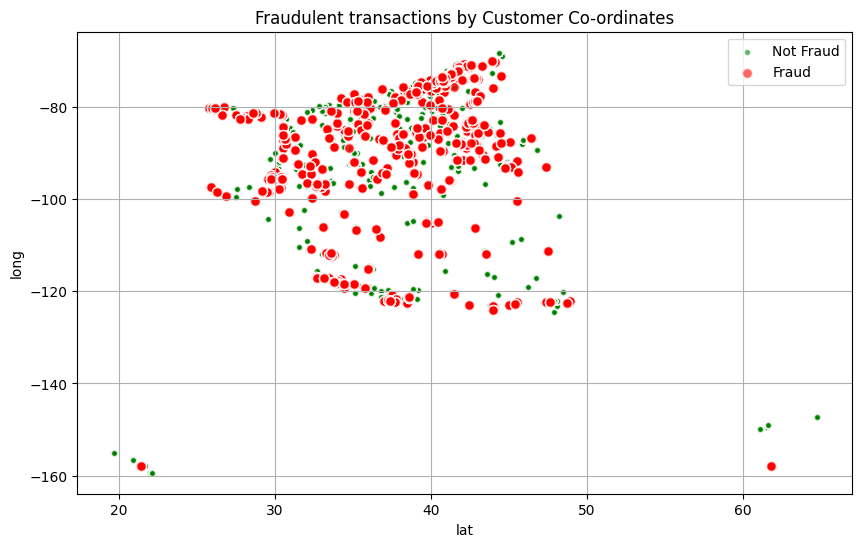

In [37]:
sctplt_2d(df_clean, 'lat', 'long', 'is_fraud', "Customer Co-ordinates")

no clear patterns here between customer co-ordinates and fraudulent transactions

## 3.2 city_pop

In [38]:
df_clean['city_pop'].describe()

count    4.260904e+06
mean     3.038011e+05
std      5.696231e+05
min      1.050000e+02
25%      2.010300e+04
50%      6.759300e+04
75%      2.420370e+05
max      2.906700e+06
Name: city_pop, dtype: float64

In [39]:
df_clean['city_pop'].value_counts()

city_pop
2504700    73200
990452     37474
940359     35307
2906700    33889
1263321    33466
           ...  
79580         12
40689         12
2901          10
254917         9
73240          7
Name: count, Length: 764, dtype: int64

In [40]:
def sctplt_fraud_rate(data, col, target):
  # unique values
  vals = data[col].unique()
  # FR dict
  FRs = {}
  # TF = {}
  # locate unique vals
  for val in vals:
    rows = data.loc[data[col] == val]
    fr = rows[target].mean()
    tf = rows[target].sum()
    freq = len(rows.index)
    num_customers = len(rows['cc_num'].unique())
    # store in a dict
    FRs[val] = [fr, freq, num_customers, tf]
  # make and display sctplt
  vals = list(FRs.keys())
  fraud_rates = [values[0] for values in FRs.values()]
  plt.figure(figsize=(10, 6))
  plt.scatter(vals, fraud_rates, label='Fraud Rate')
  plt.xlabel(f'{col}')
  plt.ylabel('Fraud Rate')
  plt.title(f'Relationship between {col} and Fraud Rate')
  plt.grid(True)
  plt.show()

  return FRs

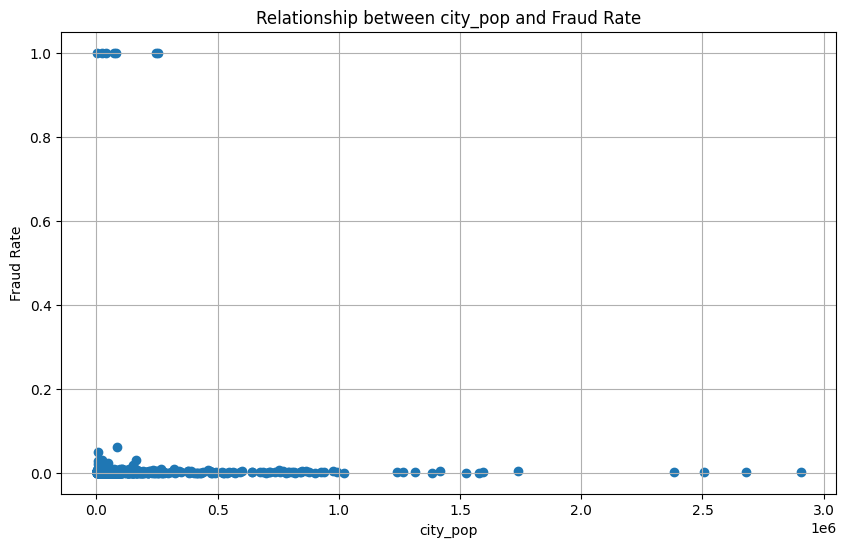

In [41]:
pop_FRs = sctplt_fraud_rate(df_clean, 'city_pop', 'is_fraud')

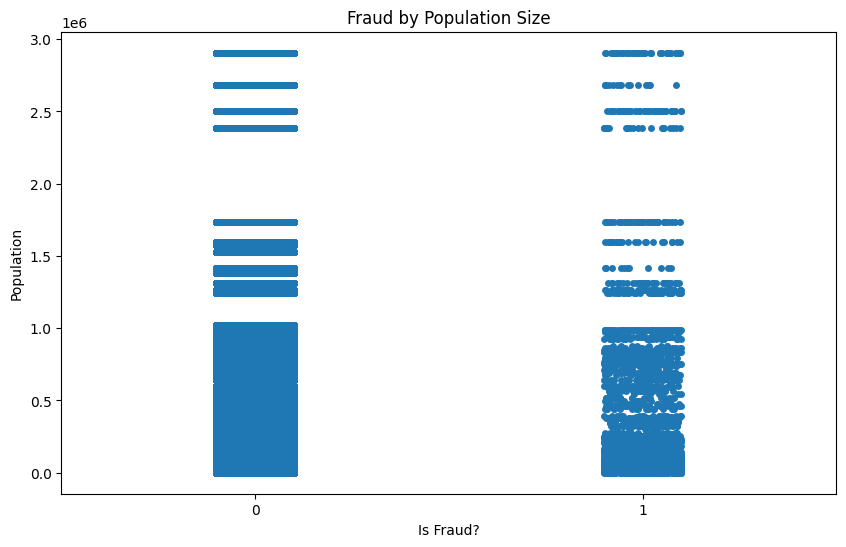

In [ ]:
plt.figure(figsize=(10, 6))
sns.stripplot(x='is_fraud', y='city_pop', data=df_clean, jitter=True)
plt.xlabel('Is Fraud?')
plt.ylabel('Population')
plt.title('Fraud by Population Size')
plt.show()

it's possible that fraud is more likely to take place in smaller cities

In [43]:
def sctplt_total_fraud(data, col, target):
  # unique values
  vals = data[col].unique()
  # FR dict
  TF = {}
  # TF = {}
  # locate unique vals
  for val in vals:
    rows = data.loc[data[col] == val]
    fr = rows[target].mean()
    tf = rows[target].sum()
    freq = len(rows.index)
    num_customers = len(rows['cc_num'].unique())
    # store in a dict
    TF[val] = [fr, freq, num_customers, tf]

  # make and display sctplt
  x = list(TF.keys())
  y = [values[3] for values in TF.values()]

  plt.figure(figsize=(10, 6))
  plt.scatter(x, y)
  plt.xlabel(f'{col}')
  plt.ylabel('Incidence of Fraud')
  plt.title(f'Fraud by {col}')
  plt.grid(True)
  plt.show()

  return TF

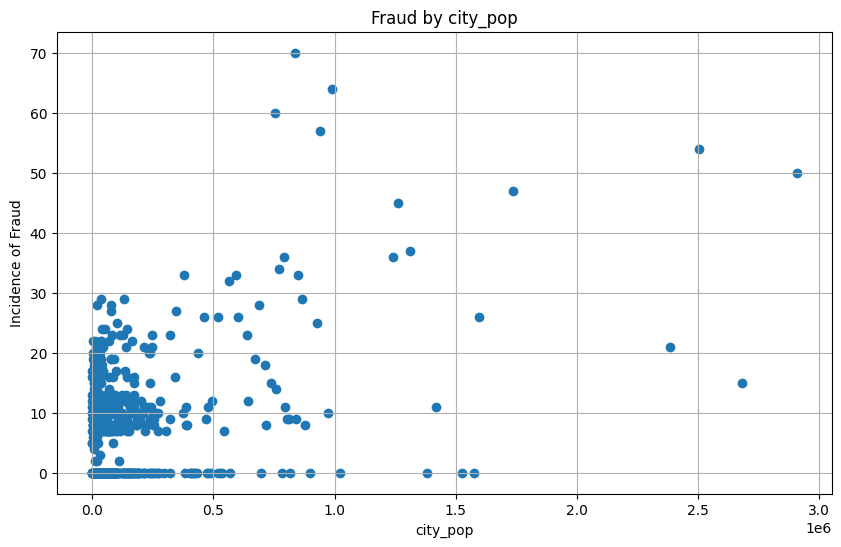

In [44]:
fraud_by_citypop = sctplt_total_fraud(df_clean, 'city_pop', 'is_fraud')

In [45]:
df_clean['city_pop']

0           32412
1           32412
2           32412
3           32412
4           32412
            ...  
4260899    341043
4260900    341043
4260901    341043
4260902    341043
4260903    341043
Name: city_pop, Length: 4260904, dtype: int64

In [46]:
print(df_clean['city_pop'].nunique())

764


## 3.3  job

In [47]:
df_clean['job'].describe()

count                      4260904
unique                         505
top       Computer games developer
freq                         33859
Name: job, dtype: object

In [48]:
jobs = df_clean['job'].unique()
print(jobs)

['Accounting technician' 'Professor Emeritus'
 'International aid/development worker' 'Seismic interpreter'
 'Medical laboratory scientific officer' 'Community arts worker'
 'Plant breeder/geneticist' 'Quarry manager' 'Retail buyer'
 'Acupuncturist' 'Surgeon' 'Television floor manager'
 'Maintenance engineer' 'Commercial art gallery manager'
 'Optician, dispensing' 'Engineer, broadcasting (operations)'
 'Health and safety inspector' 'Hydrogeologist'
 'Programme researcher, broadcasting/film/video' 'Insurance risk surveyor'
 'Solicitor' 'Recycling officer' 'Therapist, speech and language'
 'Astronomer' 'Accountant, chartered' 'Industrial buyer'
 'Magazine features editor' 'Writer' 'Pathologist' 'Energy engineer'
 'Catering manager' 'Paramedic' 'Museum/gallery curator'
 'Copywriter, advertising' 'Call centre manager'
 'Commercial horticulturist' 'Occupational therapist'
 'Agricultural engineer' 'Biochemist, clinical' 'Patent attorney'
 'Management consultant' 'Chemist, analytical' 'Thera

We want to examine possible relationship between job and is_fraud, to assess whether job is worth keeping as a variable. For each job, we can calculate an associated fraud rate by counting is_fraud=1 as a percentage of all rows for that job.

In [50]:
def fraud_rate(data, col, target):
  # unique values
  vals = data[col].unique()
  # FR dict
  FRs = {}
  # TF = {}
  # locate unique vals
  for val in vals:
    rows = data.loc[data[col] == val]
    fr = rows[target].mean()
    tf = rows[target].sum()
    freq = len(rows.index)
    num_customers = len(rows['cc_num'].unique())
    # store in a dict
    FRs[val] = [fr, freq, num_customers, tf]
  # make and display barchart
  # plt.bar(*zip(*TF.items()))
  # plt.xlabel(f"{col}")
  # plt.ylabel('Incidence of Fraud')
  # plt.title(f'Fraud incidence by {col}')
  # plt.xticks(rotation=90)
  # plt.show()

  return FRs

In [51]:
df_clean['is_fraud'].value_counts()

is_fraud
0    4255870
1       5034
Name: count, dtype: int64

In [52]:
df_clean['is_fraud'] = df_clean['is_fraud'].astype(int)

In [53]:
fraud_rates = fraud_rate(df_clean, 'job', 'is_fraud')

In [54]:
fraud_rates_df = pd.DataFrame.from_dict(fraud_rates, orient='index', columns=['Fraud Rate', 'Job Frequency', 'Number of Customers', 'Total Fraud'])
fraud_rates_df.reset_index(inplace=True)
fraud_rates_df.rename(columns={'index': 'Job'}, inplace=True)
fraud_rates_df.sort_values('Fraud Rate', inplace=True, ascending=False)
fraud_rates_df = fraud_rates_df[fraud_rates_df['Fraud Rate'] > 0]
fraud_rates_df.head(20)

,Job,Fraud Rate,Job Frequency,Number of Customers,Total Fraud
449,"Loss adjuster, chartered",1.000000,7,1,7
342,Sales executive,1.000000,7,1,7
495,"Geneticist, molecular",1.000000,12,1,12
435,Estate manager/land agent,0.047872,376,1,18
289,Transport planner,0.029810,369,1,11
493,Land,0.028610,734,1,21
241,Clinical molecular geneticist,0.018502,2216,2,41
321,Airline pilot,0.013774,726,1,10
498,"Therapist, occupational",0.013296,1805,1,24
503,"Engineer, manufacturing",0.012500,720,1,9


We think it most likely that fraud rates for job are  the result of a single victim of fraud subject to multiple fraudulent transactions, and that their job therefore likely doesn't tell us anything useful. As we can see, jobs with highest fraud rate occur for only 1 or 2 unique customers, and total fraud incidence matches frequency of that job in the data.

##  3.4     dob

In [55]:
df_clean['dob'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4260904 entries, 0 to 4260903
Series name: dob
Non-Null Count    Dtype 
--------------    ----- 
4260904 non-null  object
dtypes: object(1)
memory usage: 32.5+ MB


In [56]:
df_clean['dob'].describe()

count        4260904
unique           962
top       1999-12-23
freq           16747
Name: dob, dtype: object

Transforming dob to age for further exploration

In [57]:
df_clean['dob'] = pd.to_datetime(df_clean['dob'])
df_clean['dob'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4260904 entries, 0 to 4260903
Series name: dob
Non-Null Count    Dtype         
--------------    -----         
4260904 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 32.5 MB


In [58]:
print(df_clean.dob.min())
print(df_clean.dob.max())

1927-07-30 00:00:00
2007-08-20 00:00:00


In [59]:
df_clean['dob'].describe()

count                          4260904
mean     1977-12-28 20:19:07.936682048
min                1927-07-30 00:00:00
25%                1966-11-27 00:00:00
50%                1980-01-23 00:00:00
75%                1992-06-18 00:00:00
max                2007-08-20 00:00:00
Name: dob, dtype: object

if we stipulate 2023ish transactions, it's just about possible we could have a 96 yo customer and a 16 yo

In [60]:
df_clean['yob'] = df_clean['dob'].dt.strftime('%Y')
df_clean['yob'] = df_clean['yob'].astype(int)
df_clean['yob'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4260904 entries, 0 to 4260903
Series name: yob
Non-Null Count    Dtype
--------------    -----
4260904 non-null  int64
dtypes: int64(1)
memory usage: 32.5 MB


benchmarking age at 2023 (year immediately after latest unix timestamp in dataset)

In [61]:
df_clean['age'] = 2023 - df_clean['yob']
df_clean['age'].unique()

array([64, 60, 50, 81, 84, 47, 21, 38, 85, 56, 22, 46, 37, 31, 40, 52, 55,
       70, 51, 61, 24, 35, 65, 53, 59, 75, 58, 30, 29, 62, 89, 41, 48, 54,
       42, 45, 32, 74, 33, 39, 49, 36, 67, 68, 57, 43, 83, 69, 73, 44, 63,
       90, 25, 28, 78, 72, 82, 27, 23, 79, 34, 26, 16, 20, 95, 19, 71, 66,
       93, 86, 80, 96, 76, 18, 88, 94, 87, 77, 91, 17])

will now drop the age proxies

In [62]:
df_clean = df_clean.drop(['yob', 'dob'], axis=1)
df_clean.columns

Index(['ssn', 'cc_num', 'first', 'last', 'gender', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'trans_num', 'unix_time',
       'category', 'amt', 'is_fraud', 'merchant', 'merch_lat', 'merch_long',
       'age'],
      dtype='object')

Explore any possible relationship between age and fraud

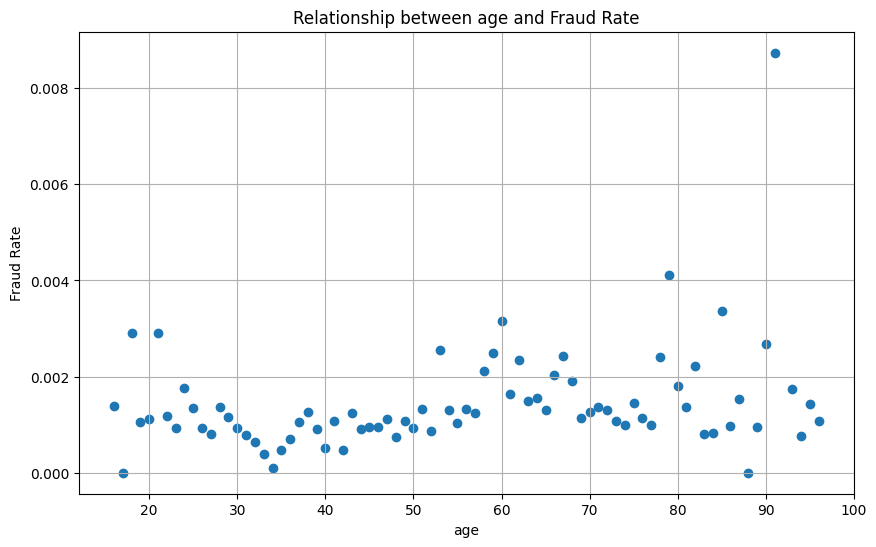

In [64]:
fraud_by_age = sctplt_fraud_rate(df_clean, 'age', 'is_fraud')

In [65]:
def fraud_rate_barchart(data, col, target):
  # unique values
  vals = data[col].unique()
  # FR dict
  FRs = {}
  # locate unique vals
  for val in vals:
    rows = data.loc[data[col] == val]
    fr = rows[target].mean()
    tf = rows[target].sum()
    freq = len(rows.index)
    num_customers = len(rows['cc_num'].unique())
    # store in a dict
    FRs[val] = [fr, freq, num_customers, tf]
  # make and display barchart
  vals = list(FRs.keys())
  fraud_rates = [values[0] for values in FRs.values()]
  plt.bar(x=vals, height=fraud_rates)
  plt.xlabel(f"{col}")
  plt.ylabel('Fraud Rate')
  plt.title(f'Fraud Rate by {col}')
  plt.xticks(rotation=90)
  plt.show()

  return FRs

In [66]:
df_clean['age'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4260904 entries, 0 to 4260903
Series name: age
Non-Null Count    Dtype
--------------    -----
4260904 non-null  int64
dtypes: int64(1)
memory usage: 32.5 MB


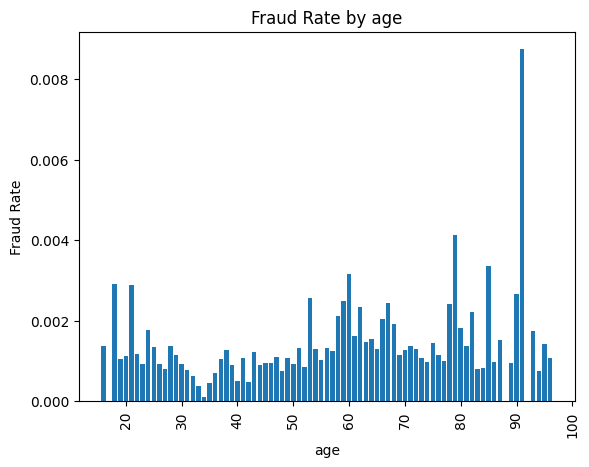

In [67]:
fraud_by_age = fraud_rate_barchart(df_clean, 'age', 'is_fraud')

Any pattern between fraud_rate and age is not especially clear. Higher fraud rates for certain ages are probably due to a small number of customers falling victim to many incidences of fraud.

## 3.5 category

In [68]:
df_clean['category'].describe()

count          4260904
unique              14
top       shopping_pos
freq            420268
Name: category, dtype: object

14 unique values for category, so manageable number of dummy columns

In [69]:
def fraud_rate_barh (data, col, target):
  # unique values
  vals = data[col].unique()
  # FR dict
  FRs = {}
  # TF = {}
  # locate unique vals
  for val in vals:
    rows = data.loc[data[col] == val]
    fr = rows[target].mean()
    tf = rows[target].sum()
    freq = len(rows.index)
    num_customers = len(rows['cc_num'].unique())
    # store in a dict
    FRs[val] = [fr, freq, num_customers, tf]

  # make and display barchart
  x = [values[0] for values in FRs.values()]
  y = list(FRs.keys())

  plt.figure(figsize=(10, 6))
  plt.barh(y, x, color='blue')
  plt.ylabel(f"{col}")
  plt.xlabel('Fraud rate')
  plt.title(f'Fraud Rates by {col}')
  plt.show()

  return FRs

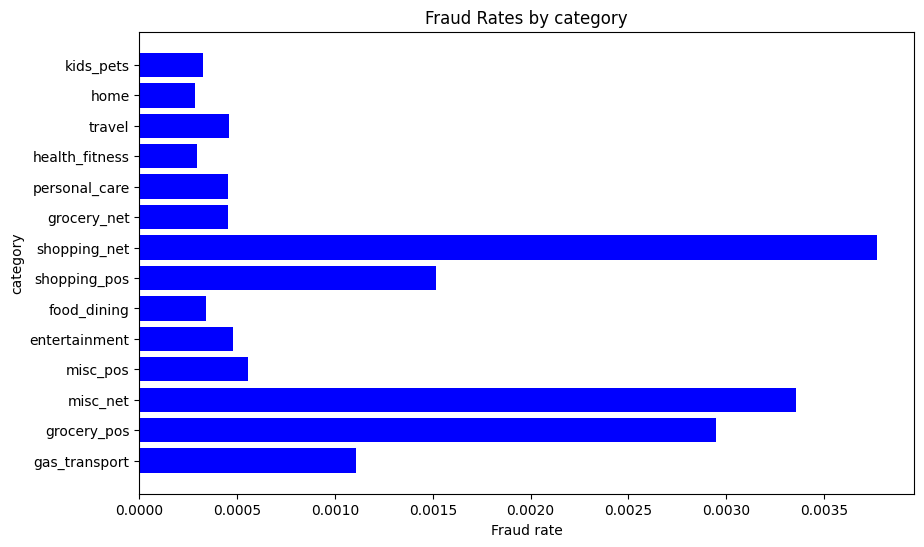

In [70]:
category_FRs = fraud_rate_barh(df_clean, 'category', 'is_fraud')

Certain types of spend category see a much higher rate of fraud than others. We will one-hot encode this column. For sparser models we could include categories in which fraud_rate exceeds 0.0005.

## 3.6 amt

In [71]:
df_clean['amt'].describe()

count    4.260904e+06
mean     6.898790e+01
std      1.618467e+02
min      1.000000e+00
25%      9.100000e+00
50%      4.449000e+01
75%      8.158000e+01
max      4.130053e+04
Name: amt, dtype: float64

In [74]:
df_clean['amt'].value_counts()

amt
1.02       1879
1.01       1842
1.04       1827
1.10       1821
1.05       1797
           ... 
905.70        1
1358.70       1
1253.92       1
4779.62       1
6383.33       1
Name: count, Length: 81218, dtype: int64

In [75]:
df_clean['amt'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4260904 entries, 0 to 4260903
Series name: amt
Non-Null Count    Dtype  
--------------    -----  
4260904 non-null  float64
dtypes: float64(1)
memory usage: 32.5 MB


we can see that Fraud is actually squashed into very smaller spends. This is useful information.

In [76]:
import seaborn as sns

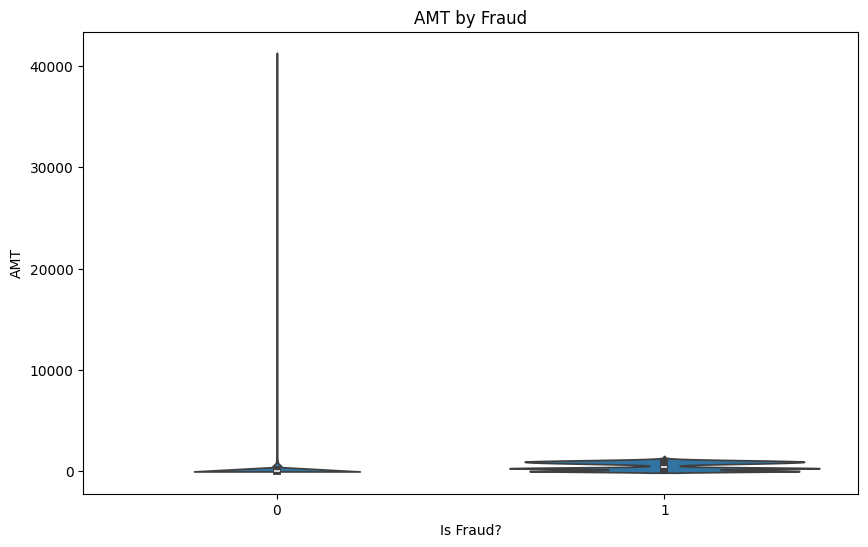

In [77]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='is_fraud', y='amt', data=df_clean)
plt.xlabel('Is Fraud?')
plt.ylabel('AMT')
plt.title('AMT by Fraud')
plt.show()

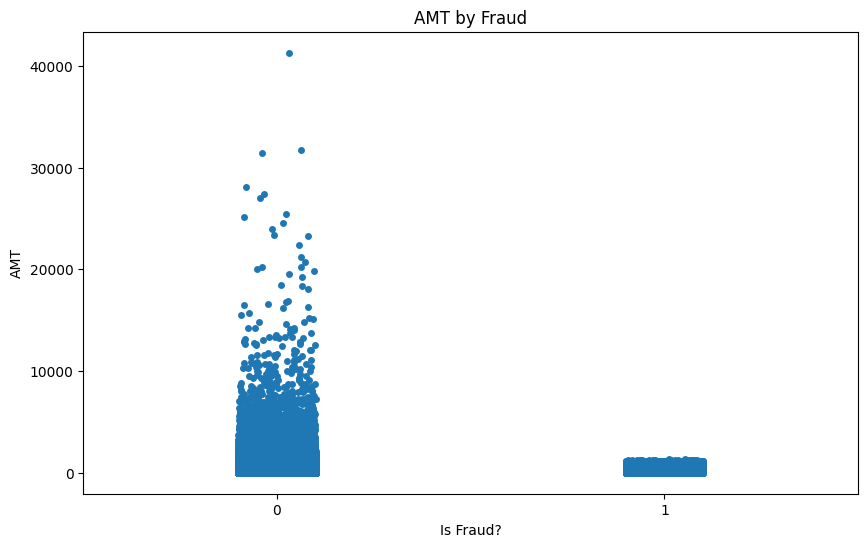

In [78]:
plt.figure(figsize=(10, 6))
sns.stripplot(x='is_fraud', y='amt', data=df_clean, jitter=True)
plt.xlabel('Is Fraud?')
plt.ylabel('AMT')
plt.title('AMT by Fraud')
plt.show()

tree based models should perform well here by splitting all samples for AMT > ~2K into the non-fraud branch.

## 3.7 merchant

We have 21987 unique values for merchant. Hard to know what we do with this, unless we perhaps create dummies which we then recompose with PCA or similar?

In [79]:
df_clean['merchant'].value_counts()

merchant
Smith PLC                    5737
Johnson LLC                  5713
Smith and Sons               5642
Smith Inc                    5456
Johnson Inc                  5243
                             ... 
Santiago-Smith                 47
Graham, Cross and Miller       44
Ray, Michael and Anderson      44
Jackson, King and Smith        44
Peterson-Adams                 43
Name: count, Length: 21977, dtype: int64

Would it be at all relevant information if we extracted merchant type e.g. "Inc", "LLC" "and Sons" (family business), name-based firms (probably partner firms like law firms, advertising firms etc.). Maybe, maybe not.

In [80]:
print(df_clean['merchant'].unique())

['Phillips Group' 'Tucker Ltd' 'Dixon PLC' ... 'Shannon-Nelson'
 'Dixon-Davis' 'King, Kirby and Price']


In [81]:
df_clean['merchant']

0                     Phillips Group
1                         Tucker Ltd
2                          Dixon PLC
3                     Lambert-Cooper
4                       Griffith LLC
                     ...            
4260899    Horton, Ware and Reynolds
4260900              Hanson and Sons
4260901                    White LLC
4260902               Snyder-Johnson
4260903                Ewing-Russell
Name: merchant, Length: 4260904, dtype: object

Merchant types we've seen so far:
- 'Group'
- 'LLC'
- 'PLC'
- 'Inc'
- 'and Sons'
- 'name-name' (partnership firms)
- then we could have a 'misc' bucket for everything else.

We'll conduct some very simple NLP to explore relationships between our estimated merchant types and incidence of fraud, i.e. is fraud more likely to occur for certain kinds of vendors.

In [82]:
df_clean['merchant_Inc'] = df_clean['merchant'].str.contains("Inc")

In [83]:
df_clean['merchant_PLC'] = df_clean['merchant'].str.contains("PLC")

In [84]:
df_clean['merchant_LLC'] = df_clean['merchant'].str.contains("Ltd|LLC")

In [85]:
df_clean['merchant_Conglomerate'] = df_clean['merchant'].str.contains("Group")

In [86]:
df_clean['merchant_Partnership'] = df_clean['merchant'].str.contains(",|(?<!Sons) and|-")

In [87]:
df_clean['merchant_Family'] = df_clean['merchant'].str.contains("and Sons")

In [88]:
merchant_cols = ['merchant', 'merchant_Inc', 'merchant_PLC', 'merchant_LLC', 'merchant_Conglomerate', 'merchant_Partnership', 'merchant_Family']

In [89]:
df_clean[merchant_cols]

,merchant,merchant_Inc,merchant_PLC,merchant_LLC,merchant_Conglomerate,merchant_Partnership,merchant_Family
0,Phillips Group,False,False,False,True,False,False
1,Tucker Ltd,False,False,True,False,False,False
2,Dixon PLC,False,True,False,False,False,False
3,Lambert-Cooper,False,False,False,False,True,False
4,Griffith LLC,False,False,True,False,False,False
...,...,...,...,...,...,...,...
4260899,"Horton, Ware and Reynolds",False,False,False,False,True,False
4260900,Hanson and Sons,False,False,False,False,True,True
4260901,White LLC,False,False,True,False,False,False
4260902,Snyder-Johnson,False,False,False,False,True,False


now find unique values which have 0 in all merchant cols

In [90]:
mask = df_clean[merchant_cols].eq(0).all(axis=1)
anomalous_merchants = df_clean[mask]
unique_merchants = anomalous_merchants['merchant'].unique()
print(unique_merchants)

[]


Pleasingly, our approach has captured all possible values in 'merchant'. We'll want to keep in merchant for the time being for EDA.

Now we can look at any relationships with the target variable

In [91]:
merchant_cols = [ 'merchant_Inc', 'merchant_PLC', 'merchant_LLC', 'merchant_Conglomerate',
       'merchant_Partnership', 'merchant_Family']

In [92]:
def dummy_fraud_rate(data, cols, target, title):
  # unique values
  # FR dict
  FR = {}

  for col in cols:
    rows = data.loc[data[col] == 1]
    fr = rows[target].mean()
    tf = rows[target].sum()
    freq = len(rows.index)
    n = len(rows['cc_num'].unique())
    FR[col] = [fr, tf, freq, n]

  # make and display barchart
  x = [values[0] for values in FR.values()]
  y = list(FR.keys())
  y = [item.replace("category_", "") for item in y]

  plt.barh(y, x)
  plt.xlabel('Fraud Rate')
  plt.ylabel(title)
  plt.title(f'Fraud Rate by {title}')

  plt.show()

  return FR

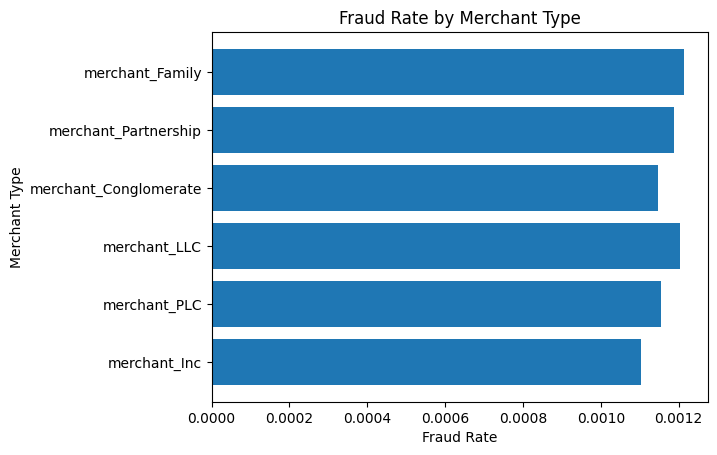

In [93]:
merchant_FRs = dummy_fraud_rate(df_clean, merchant_cols, 'is_fraud', "Merchant Type")

no clear relationship

In [94]:
def dummy_total_fraud(data, cols, target, title):
  # unique values
  # FR dict
  TF = {}

  for col in cols:
    rows = data.loc[data[col] == 1]
    fr = rows[target].mean()
    tf = rows[target].sum()
    freq = len(rows.index)
    TF[col] = [fr, tf, freq]

  # make and display barchart
  x = [values[1] for values in TF.values()]
  y = list(TF.keys())
  y = [item.replace("merchant_", "") for item in y]

  plt.barh(y, x)
  plt.ylabel(title)
  plt.xlabel('Fraud Incidence')
  plt.title(f'Fraud Incidence by {title}')
  plt.show()

  return TF

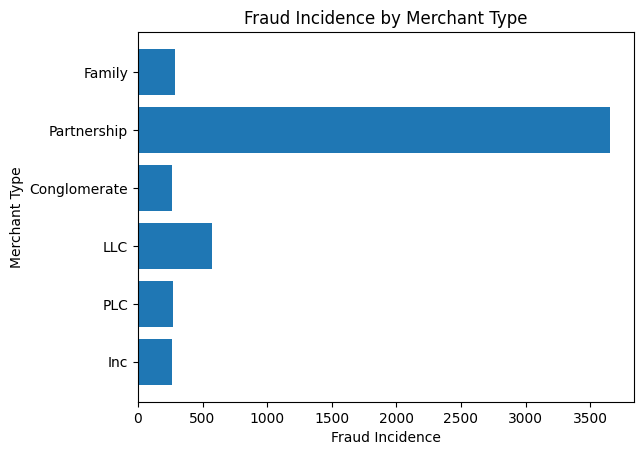

In [95]:
merchant_TF = dummy_total_fraud(df_clean, merchant_cols, 'is_fraud', "Merchant Type")

although fraud total incidence is much higher for Partnership merchants, the rate of fraud is more important for classification algos

## 3.8 merchant co-ordinates ('merch_lat' and 'merch_long')

In [96]:
df_clean['merch_lat']

0          39.491416
1          40.890319
2          39.244958
3          39.656925
4          40.313342
             ...    
4260899    27.707908
4260900    27.896372
4260901    27.110602
4260902    28.110510
4260903    27.211428
Name: merch_lat, Length: 4260904, dtype: float64

In [97]:
df_clean['merch_long']

0         -75.588522
1         -75.573359
2         -74.475327
3         -75.802342
4         -74.220434
             ...    
4260899   -82.320308
4260900   -83.387356
4260901   -82.426821
4260902   -81.891797
4260903   -83.514176
Name: merch_long, Length: 4260904, dtype: float64

In [98]:
def sctplt_2d(data, X, Y, target, title):

  x = data[X]
  y = data[Y]
  targets = data[target]

  fraud_data = data[data[target] == True]
  non_fraud_data = data[data[target] == False]

  fraud_sizes = 15
  non_fraud_sizes = 5

  plt.figure(figsize=(10, 6))
  plt.scatter(non_fraud_data[X], non_fraud_data[Y],
              c='green', alpha=0.6, edgecolors='w', s=non_fraud_sizes, label='Not Fraud')
  plt.scatter(fraud_data[X], fraud_data[Y],
              c='red', alpha=0.6, edgecolors='w', s=fraud_sizes, label='Fraud')

  plt.xlabel(f'{X}')
  plt.ylabel(f'{Y}')
  plt.title(f'Fraudulent transactions by {title}')

  plt.legend()

  plt.grid(True)
  plt.show()

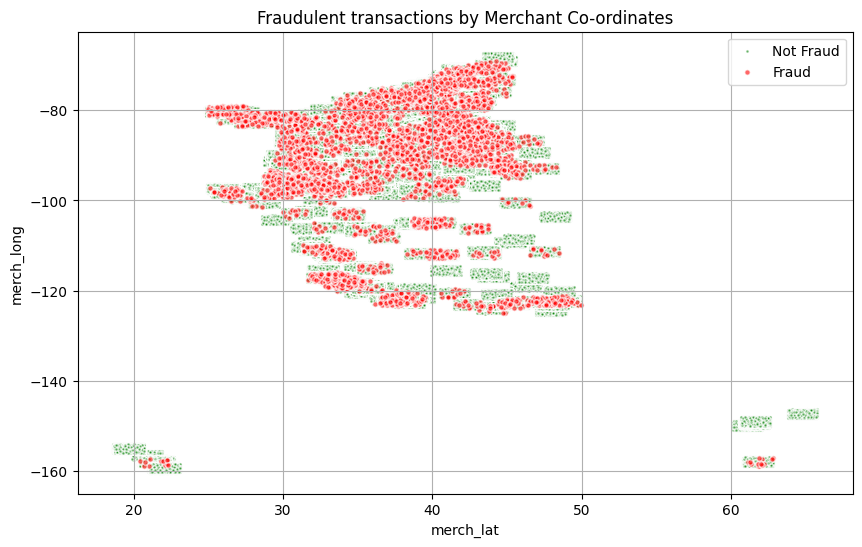

In [99]:
sctplt_2d(df_clean, 'merch_lat', 'merch_long', 'is_fraud', "Merchant Co-ordinates")

We can observe certain areas in which fraud is very unlikely to take place (the all green clusters). It's possible that MLAs could use this information. e.g. perhaps SVMs with an rbf kernel could blob out these green clusters.

## 3.9 time of transaction

unix_time gives us a way to split the dataset to make it more manageable in the short term. we'll leave this til last

In [100]:
df_clean['unix_time'].describe()

count        4260904
unique       4114752
top       1656766040
freq               5
Name: unix_time, dtype: int64

In [101]:
df_clean['unix_time'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4260904 entries, 0 to 4260903
Series name: unix_time
Non-Null Count    Dtype 
--------------    ----- 
4260904 non-null  object
dtypes: object(1)
memory usage: 32.5+ MB


convert unix_time to datetime

In [102]:
df_clean['datetime'] = pd.to_datetime(df_clean['unix_time'], unit='s')
df_clean['datetime']

0         2019-05-24 17:39:10
1         2019-09-25 15:31:59
2         2019-12-24 16:40:01
3         2019-10-18 19:50:38
4         2019-02-10 23:13:20
                  ...        
4260899   2021-07-30 09:22:23
4260900   2021-06-28 11:38:46
4260901   2021-08-24 09:37:49
4260902   2021-08-26 11:16:35
4260903   2022-11-24 02:04:28
Name: datetime, Length: 4260904, dtype: datetime64[ns]

data covers 2018-12-31 to 2022-12-31 (four years)

The data is taken over a four-year period. We'll split the data into four years.

In [103]:
df_clean['datetime'].describe()

count                          4260904
mean     2021-05-05 15:18:55.615535360
min                2018-12-31 13:00:19
25%                2020-04-21 15:19:09
50%                2021-07-16 10:27:28
75%                2022-06-11 03:24:05
max                2022-12-31 12:59:42
Name: datetime, dtype: object

## 3.10 cc_num

running a simple checksum (Luhn's algorithm) to assess whether cc_num is useful information other than just an index linking customers to transactions

Checksum function taken from Python Basics:

https://www.geeksforgeeks.org/implementing-checksum-using-python/.

In [104]:
def luhn_checksum(card_number):
    def digits_of(n):
        return [int(d) for d in str(n)]
    digits = digits_of(card_number)
    odd_digits = digits[-1::-2]
    even_digits = digits[-2::-2]
    checksum = 0
    checksum += sum(odd_digits)
    for d in even_digits:
        checksum += sum(digits_of(d*2))
    return checksum % 10

In [105]:
df_clean['cc_num'] = df['cc_num'].astype(int)

In [106]:
checksum_list = []

for num in df_clean['cc_num']:
  checksum = luhn_checksum(num)
  if (checksum==0):
    checksum_list.append("Valid")
  else:
    checksum_list.append("Invalid")

df_clean['Checksum'] = checksum_list
df_clean['Checksum'].value_counts()

Checksum
Valid    4260904
Name: count, dtype: int64

All cc_nums in the data pass the checksum, 'cc_num' only an index.

# 4. Prepare Data

In [107]:
df_cleaned = df.copy()

## 4.1 Dropping columns

Dropping:
- SSN: not relevant, data privacy issue
- Names: irrelevant, data privacy issue, no discrepancies between name and cc_num we could find
- street, city, state and zip can all be better captured by lat and long. data privacy issues.
- trans_num: too many unique values, more like an index


In [108]:
df_clean = df_clean.drop(['ssn', 'first', 'last', 'street', 'city', 'state', 'zip', 'trans_num'], axis=1)

## 4.2 Binarizing 'gender'

In [109]:
df_clean['gender'].describe()

count     4260904
unique          2
top             F
freq      2175896
Name: gender, dtype: object

Map F to 0 and M to 1

In [110]:
gender_map = {
    'F': 0,
    'M': 1
}

df_clean['gender'] = df_clean['gender'].map(gender_map)

df_clean['gender']

0          1
1          1
2          1
3          1
4          1
          ..
4260899    1
4260900    1
4260901    1
4260902    1
4260903    1
Name: gender, Length: 4260904, dtype: int64

In [111]:
df_clean['gender'].unique()

array([1, 0])

In [112]:
# age_contingencies = pd.crosstab(df_clean['gender'], df_clean['is_fraud'])
# normalized_contingencies = age_contingencies.div(age_contingencies.sum(axis=1), axis=0) * 100
# print(normalized_contingencies)

TypeError: unstack() takes from 2 to 3 positional arguments but 4 were given

Heatmap assessing any relationship with fraud

In [ ]:
sns.heatmap(normalized_contingencies, annot=True, cmap='coolwarm', fmt='.2f')
plt.xlabel('fraud')
plt.ylabel('gender')
plt.title("% Gender correlated with Fraud")
plt.show()

We can see a 0.01% difference between men and women which is just enough to merit feature inclusion for now.

## 4.4 One-hot encoding 'category'

In [113]:
df_clean['category'].unique()

array(['gas_transport', 'grocery_pos', 'misc_net', 'misc_pos',
       'entertainment', 'food_dining', 'shopping_pos', 'shopping_net',
       'grocery_net', 'personal_care', 'health_fitness', 'travel', 'home',
       'kids_pets'], dtype=object)

In [114]:
categories = pd.get_dummies(df_clean['category'], prefix='category')

In [115]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4260904 entries, 0 to 4260903
Data columns (total 14 columns):
 #   Column                   Dtype
---  ------                   -----
 0   category_entertainment   bool 
 1   category_food_dining     bool 
 2   category_gas_transport   bool 
 3   category_grocery_net     bool 
 4   category_grocery_pos     bool 
 5   category_health_fitness  bool 
 6   category_home            bool 
 7   category_kids_pets       bool 
 8   category_misc_net        bool 
 9   category_misc_pos        bool 
 10  category_personal_care   bool 
 11  category_shopping_net    bool 
 12  category_shopping_pos    bool 
 13  category_travel          bool 
dtypes: bool(14)
memory usage: 56.9 MB


In [116]:
df_clean = pd.concat([df_clean, categories], axis=1)

## 4.6 New spending pattern features based on 'amt'

Cumulative spend per customers ('cum_amt')

In [117]:
df_clean['cum_amt'] = df_clean.groupby('cc_num')['amt'].cumsum()
pd.options.display.max_rows = 100

In [118]:
pd.set_option('display.max_rows', 500)
print(df_clean['cum_amt'].head(500))

0         69.12
1        137.23
2        177.58
3        273.80
4        345.69
5        419.27
6        476.96
7        551.23
8        599.32
9        675.16
10       751.15
11       808.39
12       890.41
13       992.45
14      1062.46
15      1172.74
16      1236.71
17      1308.37
18      1391.72
19      1495.06
20      1551.07
21      1606.72
22      1682.39
23      1745.52
24      1817.60
25      1888.85
26      1962.29
27      2016.29
28      2079.44
29      2219.58
30      2319.66
31      2382.14
32      2454.86
33      2523.07
34      2622.70
35      2688.24
36      2746.28
37      2794.15
38      2887.57
39      2984.46
40      3042.47
41      3107.99
42      3173.64
43      3235.47
44      3314.11
45      3361.74
46      3447.00
47      3504.18
48      3572.77
49      3639.80
50      3686.41
51      3757.18
52      3812.26
53      3882.10
54      3965.15
55      4033.00
56      4117.58
57      4203.52
58      4269.71
59      4334.21
60      4431.07
61      4542.53
62      

In [119]:
amt_resets = df_clean.loc[df_clean['cum_amt'] < 100]
amt_resets[['cc_num', 'cum_amt']]

,cc_num,cum_amt
0,4218196001337,69.12
3278,4351161559407816183,6.87
4749,4192832764832,49.97
10561,4238849696532874,93.00
13481,4514627048281480,68.96
...,...,...
4241636,180047909863618,55.49
4248164,4371450311809,79.11
4253273,3519925692476886,71.28
4255449,343251790447085,9.18


Assessing relationship of 'cum_amt' with target

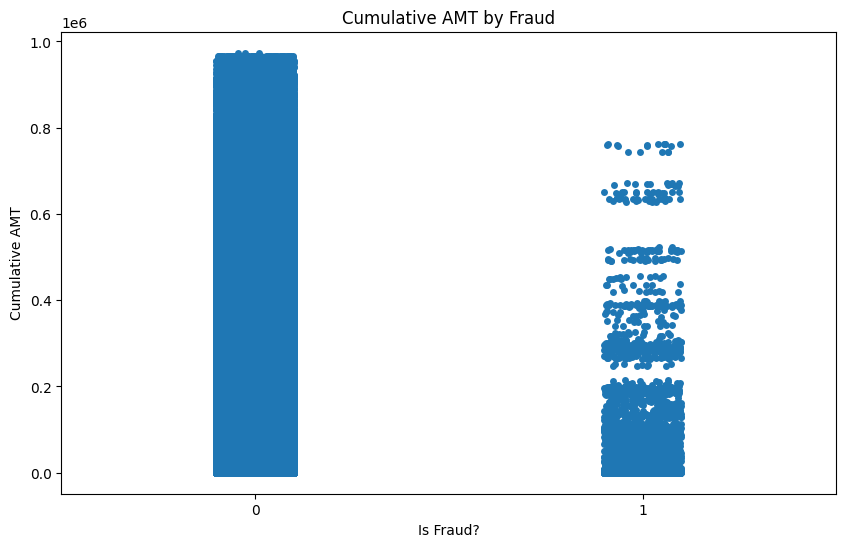

In [120]:
plt.figure(figsize=(10, 6))
sns.stripplot(x='is_fraud', y='cum_amt', data=df_clean, jitter=True)
plt.xlabel('Is Fraud?')
plt.ylabel('Cumulative AMT')
plt.title('Cumulative AMT by Fraud')
plt.show()

The plot is a little different to the analogous plot for 'amt': more spread, but the general tendency is still that lower spends are more likely to be fraudulent. 'amt' alone is probably more useful since it has a clear cut-off point, meaning 'amt' above a certain threshold can be classified as legitimate by MLAs.

Time elapsed since last spend for customers ('elapsed')

In [121]:
df_clean = df_clean.sort_values(by=['cc_num', 'datetime'])
df_clean['elapsed'] = df_clean.groupby('cc_num')['datetime'].diff()
df_clean['elapsed'] = df_clean['elapsed'].fillna(pd.Timedelta(seconds=0))
df_clean[['cc_num', 'datetime', 'elapsed']]

,cc_num,datetime,elapsed
2813780,60400268763,2018-12-31 13:55:45,0 days 00:00:00
2814981,60400268763,2019-01-01 17:43:37,1 days 03:47:52
2813034,60400268763,2019-01-02 16:46:55,0 days 23:03:18
2814146,60400268763,2019-01-03 17:34:57,1 days 00:48:02
2813850,60400268763,2019-01-04 17:46:46,1 days 00:11:49
...,...,...,...
3287965,4986226992066617996,2022-12-31 05:15:27,0 days 00:26:37
3288144,4986226992066617996,2022-12-31 07:09:30,0 days 01:54:03
3287958,4986226992066617996,2022-12-31 11:55:32,0 days 04:46:02
3287132,4986226992066617996,2022-12-31 12:25:26,0 days 00:29:54


Transform 'elapsed' to int seconds

In [122]:
df_clean['elapsed'] = df_clean['elapsed'].dt.total_seconds().astype(int)
df_clean['elapsed']

2813780         0
2814981    100072
2813034     82998
2814146     89282
2813850     87109
            ...  
3287965      1597
3288144      6843
3287958     17162
3287132      1794
3287793       499
Name: elapsed, Length: 4260904, dtype: int64

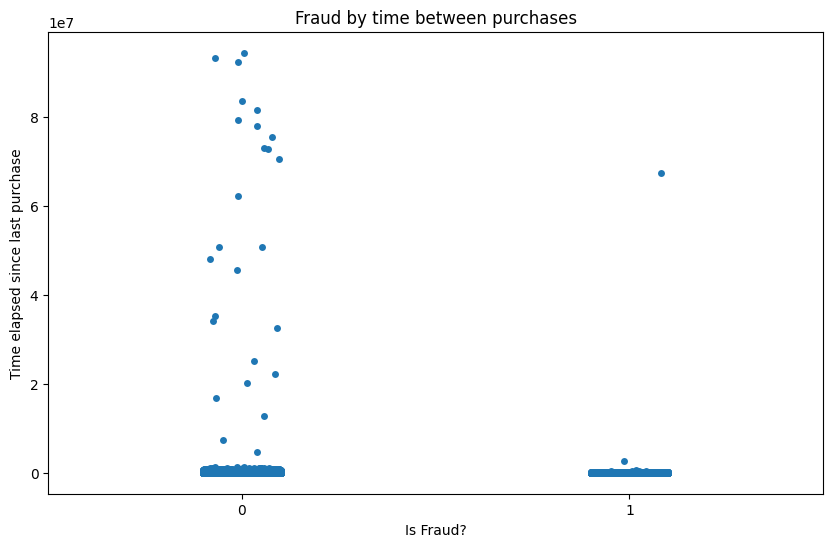

In [123]:
plt.figure(figsize=(10, 6))
sns.stripplot(x='is_fraud', y='elapsed', data=df_clean, jitter=True)
plt.xlabel('Is Fraud?')
plt.ylabel('Time elapsed since last purchase')
plt.title('Fraud by time between purchases')
plt.show()

Most likely any difference here is simply due to different sample sizes.

## 4.8 Calculating 'distance' between customer co-ordinates and merchant co-ordinates

Here we want to create a new column showing distance between customer co-ords and merch co-ords and see if it correlates with cases of fraud.

In [124]:
latitude = df_clean['lat']
longitude = df_clean['long']
merch_lat = df_clean['merch_lat']
merch_long = df_clean['merch_long']

lat_distance = abs(abs(merch_lat) - abs(latitude))
long_distance = abs(abs(merch_long) - abs(longitude))
total_distance = abs(lat_distance + long_distance)

df_clean['distance'] = total_distance
df_clean['distance'].describe()

count    4.260904e+06
mean     1.000026e+00
std      4.079767e-01
min      8.320000e-04
25%      7.073300e-01
50%      9.999530e-01
75%      1.292726e+00
max      1.999634e+00
Name: distance, dtype: float64

examine any possible relationship with fraud

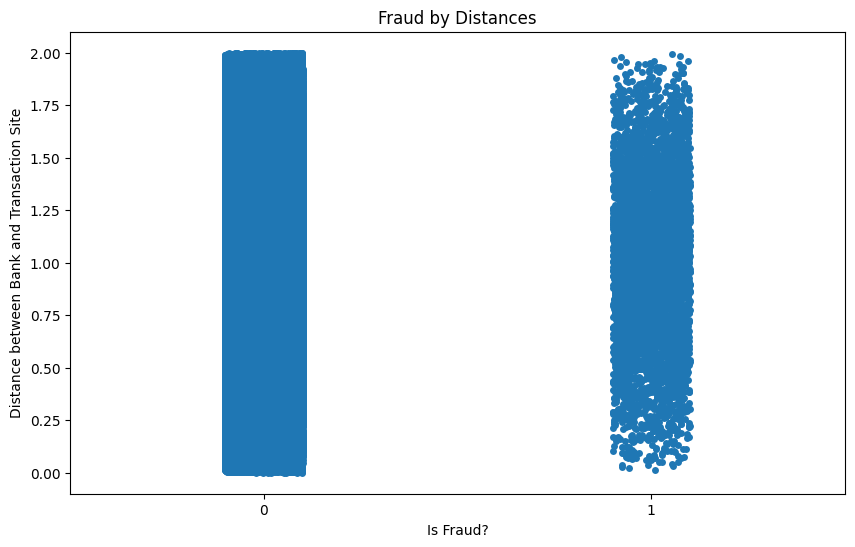

In [125]:
plt.figure(figsize=(10, 6))
sns.stripplot(x='is_fraud', y='distance', data=df_clean, jitter=True)
plt.xlabel('Is Fraud?')
plt.ylabel('Distance between Bank and Transaction Site')
plt.title('Fraud by Distances')
plt.show()

Unfortunately there is no clear relationship here. Distributions are probably the same just with lower frequencies for True.

## 4.9 Transaction Time

In [126]:
df_clean['weekday'] = df_clean['datetime'].dt.day_name()
df_clean['weekday'].describe()

count      4260904
unique           7
top       Saturday
freq        870871
Name: weekday, dtype: object

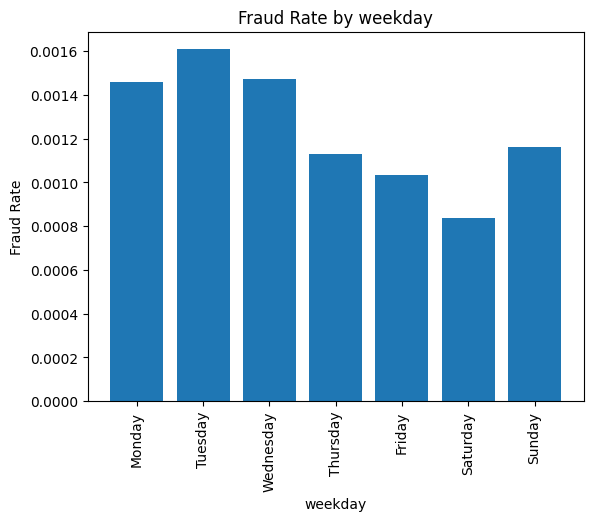

In [127]:
FR_weekday = fraud_rate_barchart(df_clean, 'weekday', 'is_fraud')

There does appear to be differences in fraud-rate over the weekly cycle. We'll turn these into dummies.

In [128]:
weekdays = pd.get_dummies(df_clean['weekday'])
weekdays

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
2813780,False,True,False,False,False,False,False
2814981,False,False,False,False,False,True,False
2813034,False,False,False,False,False,False,True
2814146,False,False,False,False,True,False,False
2813850,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...
3287965,False,False,True,False,False,False,False
3288144,False,False,True,False,False,False,False
3287958,False,False,True,False,False,False,False
3287132,False,False,True,False,False,False,False


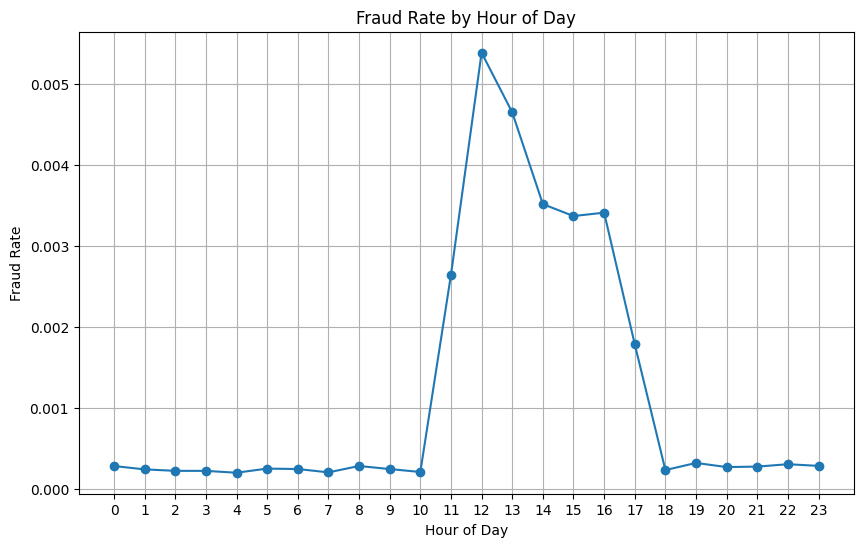

In [129]:
df_clean['hour'] = df_clean['datetime'].dt.hour

fraud_means = df_clean.groupby('hour')['is_fraud'].mean()

plt.figure(figsize=(10, 6))
plt.plot(fraud_means.index, fraud_means.values, marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Hour of Day')
plt.xticks(range(24))
plt.grid(True)
plt.show()

Very clear relationship between hour of day and fraud rate. However, this is not a linear relationship, so keeping this value as an integer would mislead models. What we could do is map hour to ranks based on the fraud-rate.

In [ ]:
hour_map = {
  0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0,
  18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0,
  17: 1,
  11: 2,
  14: 3, 15: 3, 16: 3,
  13: 4,
  12: 5
}

In [131]:
df_clean['hour_scale'] = df_clean['hour'].map(hour_map)
df_clean['hour_scale'] = df_clean['hour_scale'].astype(int)
df_clean['hour_scale'].describe()

count    4.260904e+06
mean     8.550575e-01
std      1.533220e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      5.000000e+00
Name: hour_scale, dtype: float64

In [132]:
df_clean['hour_scale'].value_counts()

hour_scale
0    3088407
3     414786
2     218061
5     217677
4     184160
1     137813
Name: count, dtype: int64

# 6. Split Dataset

saving newly created features for colleagues

In [ ]:
# new_transaction_features = ['cum_amt', 'elapsed', 'distance', 'weekday', 'hour', 'merchant_Inc', 'merchant_PLC', 'merchant_LLC',
#        'merchant_Conglomerate', 'merchant_Partnership', 'merchant_Family']

# df_new_transaction_features = df_clean[new_transaction_features]

# df_new_transaction_features.to_csv("new_transaction_features.csv")

# !cp new_transaction_features.csv drive/MyDrive/

splitting by year

In [134]:
df_clean['year'] = df_clean['datetime'].dt.year

df_2019 = df_clean[df_clean['year'] == 2019|2018]
df_2020 = df_clean[df_clean['year'] == 2020]
df_2021 = df_clean[df_clean['year'] == 2021]
df_2022 = df_clean[df_clean['year'] == 2022]

In [135]:
idx22 = df_2022.index
cats22 = categories.loc[idx22]
weekdays22 = weekdays.loc[idx22]

df_2022 = pd.concat([df_2022, cats22, weekdays22], axis=1)

In [136]:
# df_2022.to_csv("df_2022.csv")
# !cp df_2022.csv drive/MyDrive/

Assessing balances of the target class across years

In [137]:
# checking how isfraud is stratified
target = 'is_fraud'
balance_2019 = df_2019[target].value_counts()
balance_2020 = df_2020[target].value_counts()
balance_2021 = df_2021[target].value_counts()
balance_2022 = df_2022[target].value_counts()

print(balance_2019[1] / balance_2019[0])
print(balance_2020[1] / balance_2020[0])
print(balance_2021[1] / balance_2021[0])
print(balance_2022[1] / balance_2022[0])

0.0009587828112582512
0.0007119755453907754
0.0005865450749416073
0.0018435956785069257


We see actually a very significant uptick in fraud in 2022: more than triple the previous year. We will take the 2022 data as the most up-to-date in terms for purposes of fraud detection.

A possible approach would be to take the fourth financial quarter (Q4) of 2022 as testing data (most recent so closest simulation of deployment). But we will first check class balances across quarters.

In [138]:
Q4 = pd.Timestamp('2022-10-01 00:00:00')
df_Q4 = df_2022[df_2022['datetime'] >= Q4]
df_Q4

,cc_num,gender,lat,long,city_pop,job,unix_time,category,amt,is_fraud,...,category_shopping_net,category_shopping_pos,category_travel,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
2817113,60400268763,1,30.7145,-88.0918,270712,Physiological scientist,1664593543,home,194.78,0,...,False,False,False,False,False,True,False,False,False,False
2815129,60400268763,1,30.7145,-88.0918,270712,Physiological scientist,1664593921,personal_care,6.11,0,...,False,False,False,False,False,True,False,False,False,False
2816381,60400268763,1,30.7145,-88.0918,270712,Physiological scientist,1664612739,personal_care,22.53,0,...,False,False,False,False,False,True,False,False,False,False
2815635,60400268763,1,30.7145,-88.0918,270712,Physiological scientist,1664616078,personal_care,180.52,0,...,False,False,False,False,False,True,False,False,False,False
2815276,60400268763,1,30.7145,-88.0918,270712,Physiological scientist,1664628565,personal_care,8.19,0,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3287965,4986226992066617996,1,38.8097,-91.0329,9760,"Psychologist, forensic",1672463727,travel,1.47,0,...,False,False,True,False,False,True,False,False,False,False
3288144,4986226992066617996,1,38.8097,-91.0329,9760,"Psychologist, forensic",1672470570,travel,240.03,0,...,False,False,True,False,False,True,False,False,False,False
3287958,4986226992066617996,1,38.8097,-91.0329,9760,"Psychologist, forensic",1672487732,travel,22.79,0,...,False,False,True,False,False,True,False,False,False,False
3287132,4986226992066617996,1,38.8097,-91.0329,9760,"Psychologist, forensic",1672489526,travel,44.18,0,...,False,False,True,False,False,True,False,False,False,False


In [139]:
df_Q1_3 = df_2022.drop(df_Q4.index)
df_Q1_3['datetime'].describe()

count                          1165105
mean     2022-05-28 16:13:24.949872128
min                2022-01-01 01:00:33
25%                2022-03-28 02:43:37
50%                2022-06-04 06:36:44
75%                2022-07-30 08:44:58
max                2022-09-30 17:16:28
Name: datetime, dtype: object

In [140]:
print(df_Q1_3.shape)
print(df_Q4.shape)

(1165105, 64)
(517318, 64)


In [141]:
target = 'is_fraud'
balance_Q1_3 = df_Q1_3[target].value_counts()
balance_Q4 = df_Q4[target].value_counts()
print(balance_Q1_3[1] / len(df_Q1_3.index))
print(balance_Q4[1] / len(df_Q4.index))

0.0020504589715090054
0.0013666642181404862


Because of the significant difference between Q1-3 class balance and Q4 balance (nearly double), splitting into sets across quarters could be problematic. We will take the Q4 data as the most up-to-date and conduct a stratified split.

In [142]:
from sklearn.model_selection import train_test_split

Q4_data, Q4_test = train_test_split(df_Q4, test_size=0.2, random_state=40, stratify=df_Q4[target])
Q4_train, Q4_val = train_test_split(Q4_data, test_size=0.2, random_state=40, stratify=Q4_data[target])

train_balance = Q4_train[target].value_counts()
val_balance = Q4_val[target].value_counts()
test_balance = Q4_test[target].value_counts()
print(train_balance[1] / len(Q4_train.index))
print(val_balance[1] / len(Q4_val.index))
print(test_balance[1] / len(Q4_test.index))

0.0013682369677694114
0.0013652124536371435
0.0013627928554859662


Store fraud data for later use

In [143]:
# cost of fraud in 2022
fraud_22 = df_2022[df_2022['is_fraud'] == 1]
costs_22 = fraud_22['amt'].sum()
amt_22 = df_2022['amt'].sum()
relative_costs_22 = costs_22 / amt_22 * 100

print(f"Total cost of fraud in 2022: ", costs_22)
print(f"Relative cost of fraud in 2022: %",relative_costs_22)

Total cost of fraud in 2022:  1678134.21
Relative cost of fraud in 2022: % 1.4996880615012973


In [144]:
# cost of fraud in Q4 2022

fraud_Q4 = df_Q4[df_Q4['is_fraud'] == 1]
costs_Q4 = fraud_Q4['amt'].sum()
amt_Q4 = df_Q4['amt'].sum()
relative_costs_Q4 = costs_Q4 / amt_Q4 * 100

print(f"Total cost of fraud in 2022: ", costs_Q4)
print(f"Relative cost of fraud in 2022: %", relative_costs_Q4)

Total cost of fraud in 2022:  355728.63
Relative cost of fraud in 2022: % 1.0767157857806693


Clearing up memory

In [145]:
del df_2019, df_2020, df_2021, df_Q1_3, acct_num_discrepancies, acct_nums_df, cc_nums, df

In [146]:
del Q4_data

In [147]:
del checksum_list, customers, df_cleaned, idx22, mask, merch_lat, merch_long, longitude, long_distance, lat_distance, total_distance, transactions, weekdays22

In [148]:
del amt_resets, by_acct_num, by_cc_num, cats22, latitude

In [149]:
Q4_train.columns

Index(['cc_num', 'gender', 'lat', 'long', 'city_pop', 'job', 'unix_time',
       'category', 'amt', 'is_fraud', 'merchant', 'merch_lat', 'merch_long',
       'age', 'merchant_Inc', 'merchant_PLC', 'merchant_LLC',
       'merchant_Conglomerate', 'merchant_Partnership', 'merchant_Family',
       'datetime', 'Checksum', 'category_entertainment',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'cum_amt', 'elapsed', 'distance', 'weekday', 'hour', 'hour_scale',
       'year', 'category_entertainment', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net'

In [150]:
X_cols = ['city_pop', 'amt', 'merch_lat', 'merch_long', 'age', 'gender', 'hour',
'category_entertainment', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']

X_train = Q4_train[X_cols]
X_val = Q4_val[X_cols]
X_test = Q4_test[X_cols]

In [151]:
y_train = Q4_train.pop('is_fraud')
y_val = Q4_val.pop('is_fraud')
y_test = Q4_test.pop('is_fraud')

In [152]:
del Q4_train, Q4_val, Q4_test, categories, weekdays

Generating pseudo-randomly undersampled sets to:

1. make model fitting more manageable.
2. balance class weights to prioritize minority class.

In [153]:
from sklearn.utils import compute_class_weight

cw = (compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)).round().astype(int)
cw_dict = {i: cw[i] for i in range(len(cw))}
sample_weights = np.array([cw_dict[label] for label in y_train])

cw_dict

{0: 1, 1: 365}

In [154]:
print(X_train.shape)
print(y_train.shape)

(331083, 42)
(331083,)


In [155]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(sampling_strategy=cw_dict, random_state=40)
X_balanced, y_balanced = undersampler.fit_resample(X_train, y_train)
print(X_balanced.shape)
print(y_balanced.shape)

(366, 42)
(366,)


#### 6.2 Post-split feature engineering

The feature engineering techniques we use here would risk contaminating the validation and test sets, so we fit these techniques with training data (with evaluation) before applying them to validation and test data (without evaluation).

##### 6.2.1 Finding fraud hotspots with K-Means

- cluster by co-ordinates and is_fraud.
- fit Kmeans with training data.
- Use same Kmeans to label val and test data.

geographic distribution of fraud in the 2022 data

In [156]:
def sctplt_2d(data, X, Y, target, title):

  x = data[X]
  y = data[Y]
  targets = data[target]

  fraud_data = data[data[target] == True]
  non_fraud_data = data[data[target] == False]

  fraud_sizes = 15
  non_fraud_sizes = 5

  plt.figure(figsize=(10, 6))
  plt.scatter(non_fraud_data[X], non_fraud_data[Y],
              c='green', alpha=0.6, edgecolors='w', s=non_fraud_sizes, label='Not Fraud')
  plt.scatter(fraud_data[X], fraud_data[Y],
              c='red', alpha=0.6, edgecolors='w', s=fraud_sizes, label='Fraud')

  plt.xlabel(f'{X}')
  plt.ylabel(f'{Y}')
  plt.title(f'Fraudulent transactions by {title}')

  plt.legend()

  plt.grid(True)
  plt.show()

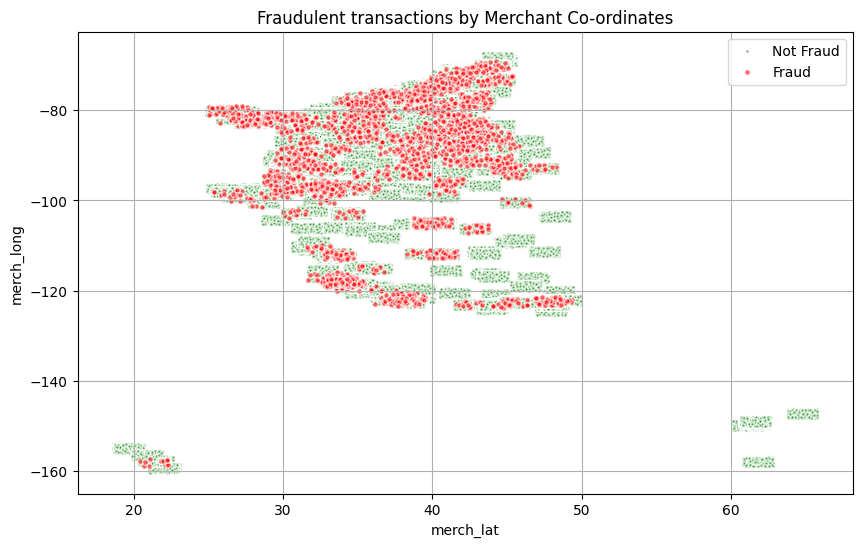

In [157]:
sctplt_2d(df_2022, 'merch_lat', 'merch_long', 'is_fraud', "Merchant Co-ordinates")

In [158]:
fraud_index = y_train == 1
fraud_index = fraud_index[fraud_index==True]
fraud_index = fraud_index.index
fraud_index
fraud_sites_rows = X_train.loc[fraud_index]
fraud_sites_rows
fraud_geodata = fraud_sites_rows[['merch_lat', 'merch_long']]
fraud_geodata

,merch_lat,merch_long
3892218,41.881309,-71.327623
243356,42.096473,-81.591599
1668622,43.820860,-70.805749
3752963,27.243652,-97.994113
1824006,41.779637,-88.497439
3192977,30.772765,-92.896278
319863,36.148686,-77.151728
2095256,45.177855,-87.599870
452655,43.242016,-76.970337
98616,30.864606,-82.203094


In [159]:
cluster_df = pd.DataFrame()
inertia_list = []
silhouette_scores = []

silhouette_values = {}

In [160]:
cluster_df['cluster'] = np.arange(2, 30, 1)

In [161]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

for k in cluster_df['cluster']:
  kmeans = KMeans(n_clusters=k, random_state=30).fit(fraud_geodata)
  inertia_list.append(kmeans.inertia_)
  silhouette_avg = silhouette_score(fraud_geodata, kmeans.labels_)
  silhouette_scores.append(silhouette_avg)
  silhouette_values[k] = silhouette_samples(fraud_geodata, kmeans.labels_)

In [162]:
cluster_df['inertia'] = inertia_list
cluster_df['silhouette_score'] = silhouette_scores

In [163]:
missing_data = fraud_geodata.isnull().any(axis=1)
missing_data.loc[missing_data==True]

Series([], dtype: bool)

In [164]:
import altair as alt

inertia_chart = alt.Chart(cluster_df).mark_line().encode(
    x='cluster',
    y='inertia'
).properties(title="Inertia reduction by additional K-Means Clusters")

inertia_chart

alt.Chart(...)

10 clusters looks like a good kink and gives us plenty of hotspots

In [165]:
data = pd.DataFrame({
    'merch_lat': X_train['merch_lat'],
    'merch_long': X_train['merch_long'],
    'is_fraud': y_train.values
})

silhouette scores

In [166]:
cluster_df

,cluster,inertia,silhouette_score
0,2,36320.206897,0.569814
1,3,20475.953911,0.490427
2,4,15297.217545,0.495944
3,5,10674.437865,0.529692
4,6,7695.589331,0.543714
5,7,6267.055889,0.523137
6,8,4971.905624,0.544814
7,9,4155.916372,0.545979
8,10,3357.280741,0.570286
9,11,3028.284517,0.561361


In [167]:
cluster_df['inertia'] = cluster_df['inertia'].round().astype(int)
cluster_df.insert(2, 'inertia_diff', (cluster_df['inertia'].diff()).round().astype(int, errors='ignore'))
cluster_df.insert(3, 'relative_inertia_diff', value=((cluster_df['inertia_diff'] / cluster_df['inertia'].shift()) * 100).round())
cluster_df['silhouette_score'] = (cluster_df['silhouette_score']).round(3)
cluster_df['ss_improvement'] = cluster_df['silhouette_score'].diff()
cluster_df['inertia_diff'] = cluster_df['inertia_diff'].round().astype(int, errors='ignore')


def format_percent(value):
  try:
    return f'{value}%'
  except (ValueError, TypeError):
    return "NA"

cluster_df['relative_inertia_diff'] = cluster_df['relative_inertia_diff'].apply(format_percent)

cluster_df

,cluster,inertia,inertia_diff,relative_inertia_diff,silhouette_score,ss_improvement
0,2,36320,NaN,nan%,0.570,NaN
1,3,20476,-15844.0,-44.0%,0.490,-0.080
2,4,15297,-5179.0,-25.0%,0.496,0.006
3,5,10674,-4623.0,-30.0%,0.530,0.034
4,6,7696,-2978.0,-28.0%,0.544,0.014
5,7,6267,-1429.0,-19.0%,0.523,-0.021
6,8,4972,-1295.0,-21.0%,0.545,0.022
7,9,4156,-816.0,-16.0%,0.546,0.001
8,10,3357,-799.0,-19.0%,0.570,0.024
9,11,3028,-329.0,-10.0%,0.561,-0.009


In [168]:
cluster_df

,cluster,inertia,inertia_diff,relative_inertia_diff,silhouette_score,ss_improvement
0,2,36320,NaN,nan%,0.570,NaN
1,3,20476,-15844.0,-44.0%,0.490,-0.080
2,4,15297,-5179.0,-25.0%,0.496,0.006
3,5,10674,-4623.0,-30.0%,0.530,0.034
4,6,7696,-2978.0,-28.0%,0.544,0.014
5,7,6267,-1429.0,-19.0%,0.523,-0.021
6,8,4972,-1295.0,-21.0%,0.545,0.022
7,9,4156,-816.0,-16.0%,0.546,0.001
8,10,3357,-799.0,-19.0%,0.570,0.024
9,11,3028,-329.0,-10.0%,0.561,-0.009


10 clusters gives us a 3% improvement in silhouette score and 25% inertia drop.

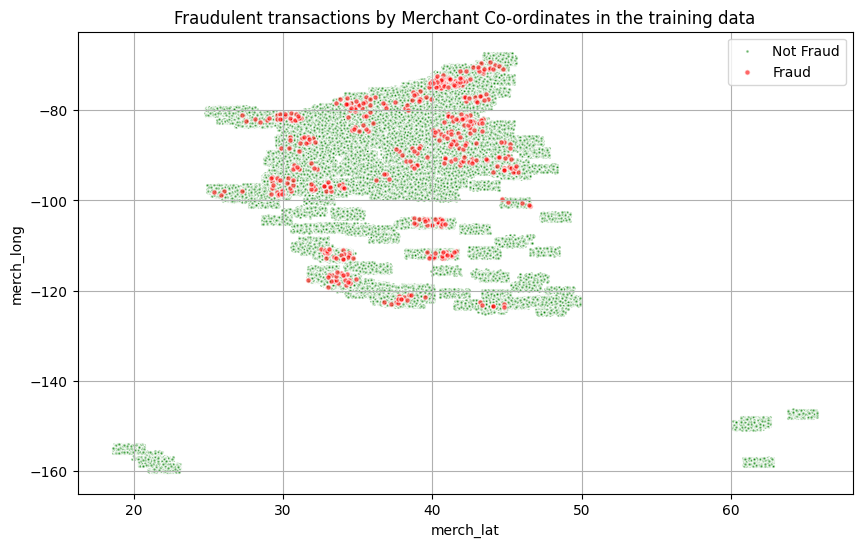

In [169]:
sctplt_2d(data, 'merch_lat', 'merch_long', 'is_fraud', "Merchant Co-ordinates in the training data")

- 3 clusters most obvious elbow
- another kink at 5 clusters
-> we'll take 5 since we want more clusters rather than fewer (we can see many hotspots on the scatterplot).

In [170]:
km = KMeans(random_state=30, n_clusters=10)

km.fit(fraud_geodata)

KMeans(n_clusters=10, random_state=30)

in general the clusters should be labelled by how well they group together fraud, so 0 should be highest value and 20 should be lowest.
we can flip values by the negative exponent, so 20 becomes 1/20, and 1 remains 1. First we'll simply add one to all values so this will work for zero.

In [171]:
geodata = ['merch_lat', 'merch_long']
geo_train = X_train[geodata]
geo_val = X_val[geodata]
geo_test = X_test[geodata]

X_train['transaction_zone'] = km.predict(geo_train) + 1
X_val['transaction_zone'] = km.predict(geo_val) + 1
X_test['transaction_zone'] = km.predict(geo_test) + 1

In [172]:
X_train['transaction_zone']

2996873    6
2072990    6
3493796    3
438540     8
3725860    7
          ..
655319     1
3702317    1
1096177    1
4018604    6
1400853    1
Name: transaction_zone, Length: 331083, dtype: int32

In [173]:
X_train['transaction_zone'].describe()

count    331083.000000
mean          5.221990
std           2.912268
min           1.000000
25%           3.000000
50%           6.000000
75%           8.000000
max          10.000000
Name: transaction_zone, dtype: float64

In [174]:
X_train['transaction_zone'].value_counts()

transaction_zone
6     58016
1     44339
4     38829
10    38057
8     36600
3     36502
2     33125
7     30686
9     10647
5      4282
Name: count, dtype: int64

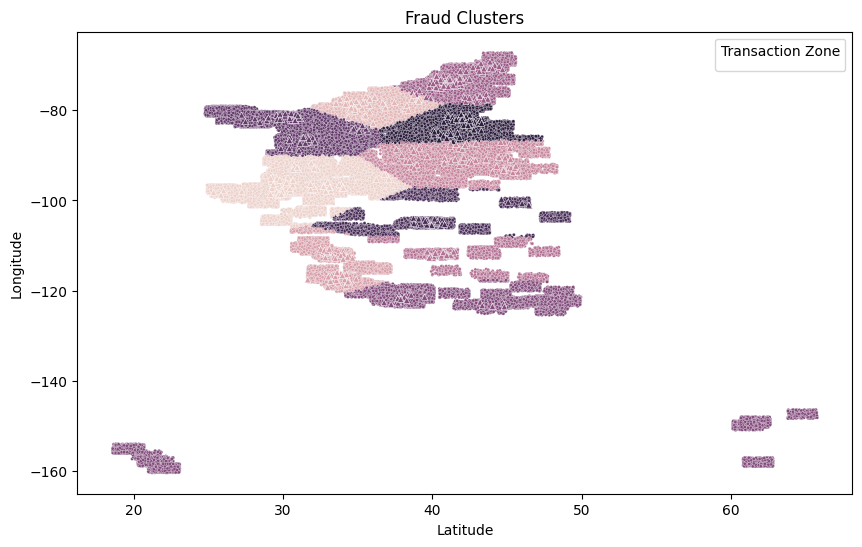

In [175]:
import seaborn as sns

data = pd.DataFrame({
    'merch_lat': X_train['merch_lat'],
    'merch_long': X_train['merch_long'],
    'transaction_zone': X_train['transaction_zone'],
    'is_fraud': y_train.values
})

data_legit = data[data['is_fraud'] == 0]
data_fraud = data[data['is_fraud'] == 1]

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=data_legit,
    x='merch_lat',
    y='merch_long',
    hue='transaction_zone',
    style='is_fraud',
    markers={0: 'o'},
    s=5,
    legend=False
)

sns.scatterplot(
    data=data_fraud,
    x='merch_lat',
    y='merch_long',
    hue='transaction_zone',
    style='is_fraud',
    markers={1: '^'},
    s=20,
    legend=False
)

plt.title("Fraud Clusters")
plt.xlabel("Latitude")
plt.ylabel("Longitude")

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[1:], labels=labels[1:], title="Transaction Zone")

plt.show()

In [176]:
import altair as alt
alt.data_transformers.disable_max_rows()

data = pd.DataFrame({
    'merch_lat': X_train['merch_lat'],
    'merch_long': X_train['merch_long'],
    'transaction_zone': X_train['transaction_zone'],
    'is_fraud': y_train.values
})

cluster_chart = alt.Chart(data).mark_point().encode(
    x=alt.X('merch_lat:Q', title="Latitude", scale=alt.Scale(domain=[15, 70])),
    y=alt.Y('merch_long:Q', title="Longitude", scale=alt.Scale(domain=[-180, -60])),
    color='transaction_zone:N',
    shape='is_fraud:N').properties(
        title="Transaction Zones",
        width=600,
        height=400)

In [177]:
cluster_chart

Output hidden; open in https://colab.research.google.com to view.

In [178]:
hotspots = km.cluster_centers_
hotspots

array([[  31.25365937,  -96.30771386],
       [  35.9102186 ,  -78.91240382],
       [  33.62421589, -114.72978053],
       [  42.22233857,  -90.58534915],
       [  40.64317871, -112.07984729],
       [  41.61380041,  -73.86424657],
       [  39.60147014, -122.2641615 ],
       [  31.12840909,  -83.85383613],
       [  40.96312572, -103.98867545],
       [  41.78970872,  -83.43716326]])

In [179]:
# calculate distance from nearest hotspot by:
#   taking coordinates of assigned cluster
#   calculating absolute value of

from sklearn.metrics import pairwise_distances_argmin_min

train_distances_df = pd.DataFrame(index=X_train.index)
val_distances_df = pd.DataFrame(index=X_val.index)
test_distances_df = pd.DataFrame(index=X_test.index)

train_closest, train_distances = pairwise_distances_argmin_min(geo_train, hotspots)
val_closest, val_distances = pairwise_distances_argmin_min(geo_val, hotspots)
test_closest, test_distances = pairwise_distances_argmin_min(geo_test, hotspots)

train_distances_df['hotspot_distance'] = train_distances
val_distances_df['hotspot_distance'] = val_distances
test_distances_df['hotspot_distance'] = test_distances

X_train['hotspot_distance'] = train_distances_df['hotspot_distance']
X_val['hotspot_distance'] = val_distances_df['hotspot_distance']
X_test['hotspot_distance'] = test_distances_df['hotspot_distance']

dropping co-ordinate data

In [180]:
X_train.drop(['merch_lat', 'merch_long'], axis=1, inplace=True)
X_val.drop(['merch_lat', 'merch_long'], axis=1, inplace=True)
X_test.drop(['merch_lat', 'merch_long'], axis=1, inplace=True)

In [181]:
X_train.columns

Index(['city_pop', 'amt', 'age', 'gender', 'hour', 'category_entertainment',
       'category_entertainment', 'category_food_dining',
       'category_food_dining', 'category_gas_transport',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_net', 'category_grocery_pos', 'category_grocery_pos',
       'category_health_fitness', 'category_health_fitness', 'category_home',
       'category_home', 'category_kids_pets', 'category_kids_pets',
       'category_misc_net', 'category_misc_net', 'category_misc_pos',
       'category_misc_pos', 'category_personal_care', 'category_personal_care',
       'category_shopping_net', 'category_shopping_net',
       'category_shopping_pos', 'category_shopping_pos', 'category_travel',
       'category_travel', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday', 'transaction_zone', 'hotspot_distance'],
      dtype='object')

##### 6.2.2 Anomaly detection

The idea here is to use our Anomaly Detectors to generate labels and scores to use as features. Again, we'll assess how well they correspond to fraud labels for the training set but not for val or test set. We'll fit to trainng data but predict on all sets to avoid contamination.

Removing features based on EDA: if there are anomalies in these cols they will be misleading. dropping unneeded geodata which is covariant with new cluster data.

In [182]:
# remove location data before training

Xa_train = X_train.drop(['amt', 'city_pop', 'gender'], axis=1)
Xa_val = X_val.drop(['amt', 'city_pop', 'gender'], axis=1)
Xa_test = X_test.drop(['amt', 'city_pop', 'gender'], axis=1)

We invert the values of the transaction zones by raising to the negative power, since the first clusters represented the most fraudulent zones.

In [183]:
# invert hotspot values

Xa_train['transaction_zone'] = Xa_train['transaction_zone'].astype(float) ** -1
Xa_val['transaction_zone'] = Xa_val['transaction_zone'].astype(float) ** -1
Xa_test['transaction_zone'] = Xa_test['transaction_zone'].astype(float) ** -1

In [184]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().set_output(transform="pandas")

scaler.fit(Xa_train)
Xa_train_scaled = scaler.transform(Xa_train)

In [185]:
Xa_val_scaled = scaler.transform(Xa_val)
Xa_test_scaled = scaler.transform(Xa_test)

###### 6.2.2.1 Local Outlier Factor for Novelty Detection (best results with this approach)

In [186]:
Xa_train_scaled['class'] = y_train.map({0: 1, 1: -1})
train_classes = Xa_train_scaled.pop('class')

In [187]:
outliers_mask = train_classes == -1
X_outliers = Xa_train_scaled.loc[outliers_mask]
X_normal = Xa_train_scaled.loc[~outliers_mask]
print(X_outliers.shape)
print(X_normal.shape)

(453, 39)
(330630, 39)


In [188]:
X_normal.columns

Index(['age', 'hour', 'category_entertainment', 'category_entertainment',
       'category_food_dining', 'category_food_dining',
       'category_gas_transport', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_net', 'category_grocery_pos',
       'category_grocery_pos', 'category_health_fitness',
       'category_health_fitness', 'category_home', 'category_home',
       'category_kids_pets', 'category_kids_pets', 'category_misc_net',
       'category_misc_net', 'category_misc_pos', 'category_misc_pos',
       'category_personal_care', 'category_personal_care',
       'category_shopping_net', 'category_shopping_net',
       'category_shopping_pos', 'category_shopping_pos', 'category_travel',
       'category_travel', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday', 'transaction_zone', 'hotspot_distance'],
      dtype='object')

In [189]:
X_new = X_normal.sample(453)
X_normal = X_normal.drop(X_new.index)
X_new = pd.concat([X_new, X_outliers])
print(X_new.shape)
print(X_normal.shape)

(906, 39)
(330177, 39)


In [190]:
class_normal = train_classes.loc[X_normal.index]
class_new = train_classes.loc[X_new.index]

In [191]:
# converting X to np array to speed up LOF runtime

Xn_np = np.array(X_normal)

In [192]:
from sklearn.neighbors import LocalOutlierFactor

lof_nov = LocalOutlierFactor(n_neighbors=21, novelty=True).fit(Xn_np)

preds_nov = lof_nov.predict(X_new)

from collections import Counter

pred_counts = Counter(preds_nov)
class_counts = class_new.value_counts()
outlier_pred_share = pred_counts[-1] / len(preds_nov) * 100
print(f"LOF predicts {outlier_pred_share}% of samples are outliers")

LOF predicts 43.377483443708606% of samples are outliers


In [193]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print(classification_report(class_new, preds_nov))

              precision    recall  f1-score   support

          -1       0.99      0.86      0.92       453
           1       0.88      1.00      0.93       453

    accuracy                           0.93       906
   macro avg       0.94      0.93      0.93       906
weighted avg       0.94      0.93      0.93       906



Text(0.5, 1.0, 'Confusion Matrix for Local Outlier Factor')

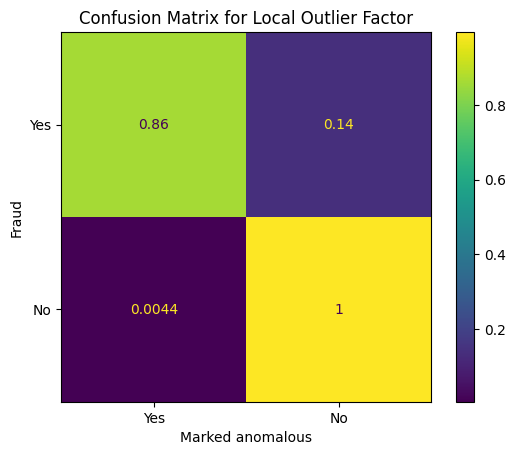

In [194]:
lof_CM = ConfusionMatrixDisplay.from_predictions(class_new, preds_nov, normalize='true')

lof_CM.ax_.set_xlabel("Marked anomalous")
lof_CM.ax_.set_ylabel("Fraud")
lof_CM.ax_.set_xticklabels(["Yes", "No"])
lof_CM.ax_.set_yticklabels(["Yes", "No"])
lof_CM.ax_.set_title("Confusion Matrix for Local Outlier Factor")

storing outlier factor for X_train, and creating scores for val and test data.

In [195]:
normal_index = X_normal.index
new_index = X_new.index

X_train['lof_nov_score'] = float('nan')
X_train.loc[normal_index, 'lof_nov_score'] = lof_nov.negative_outlier_factor_
new_scores = lof_nov.score_samples(X_new)
X_train.loc[new_index, 'lof_nov_score'] = new_scores

In [196]:
X_val['lof_nov_score'] = lof_nov.score_samples(Xa_val_scaled)
X_test['lof_nov_score'] = lof_nov.score_samples(Xa_test_scaled)

In [197]:
X_train['lof_nov_score']

2996873   -0.956609
2072990   -1.002837
3493796   -0.968214
438540    -1.033400
3725860   -0.997024
             ...   
655319    -0.997604
3702317   -1.149894
1096177   -1.017761
4018604   -1.111011
1400853   -1.069156
Name: lof_nov_score, Length: 331083, dtype: float64

In [198]:
X_val['lof_nov_score']
X_test['lof_nov_score']

4173279   -1.174313
2654639   -0.981871
806809    -1.012019
1407326   -1.037715
2593023   -1.062553
             ...   
2462818   -1.065007
3642446   -1.108699
2398822   -1.030612
3640917   -0.987334
1784821   -1.018502
Name: lof_nov_score, Length: 103464, dtype: float64

In [199]:
X_train['lof_nov_score'].describe()

count    331083.000000
mean         -1.539076
std          16.976304
min       -1990.691581
25%          -1.056426
50%          -1.017500
75%          -0.995430
max          -0.911043
Name: lof_nov_score, dtype: float64

In [200]:
X_val['lof_nov_score'].describe()

count    82771.000000
mean        -1.579865
std         17.961769
min      -1874.806500
25%         -1.062344
50%         -1.022053
75%         -0.998201
max         -0.911943
Name: lof_nov_score, dtype: float64

In [201]:
X_test['lof_nov_score'].describe()

count    103464.000000
mean         -1.552626
std          19.650296
min       -3378.882103
25%          -1.062216
50%          -1.021977
75%          -0.998000
max          -0.914756
Name: lof_nov_score, dtype: float64

Inverting values so that higher scores represent more abnormal samples

In [202]:
X_train['lof_nov_score'] = X_train['lof_nov_score'] * -1
X_val['lof_nov_score'] = X_val['lof_nov_score'] * -1
X_test['lof_nov_score'] = X_test['lof_nov_score'] * -1

###### 6.2.2.2 Isolation Forest

In [203]:
X_train.columns

Index(['city_pop', 'amt', 'age', 'gender', 'hour', 'category_entertainment',
       'category_entertainment', 'category_food_dining',
       'category_food_dining', 'category_gas_transport',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_net', 'category_grocery_pos', 'category_grocery_pos',
       'category_health_fitness', 'category_health_fitness', 'category_home',
       'category_home', 'category_kids_pets', 'category_kids_pets',
       'category_misc_net', 'category_misc_net', 'category_misc_pos',
       'category_misc_pos', 'category_personal_care', 'category_personal_care',
       'category_shopping_net', 'category_shopping_net',
       'category_shopping_pos', 'category_shopping_pos', 'category_travel',
       'category_travel', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday', 'transaction_zone', 'hotspot_distance',
       'lof_nov_score'],
      dtype='object')

In [204]:
X_train.columns

Index(['city_pop', 'amt', 'age', 'gender', 'hour', 'category_entertainment',
       'category_entertainment', 'category_food_dining',
       'category_food_dining', 'category_gas_transport',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_net', 'category_grocery_pos', 'category_grocery_pos',
       'category_health_fitness', 'category_health_fitness', 'category_home',
       'category_home', 'category_kids_pets', 'category_kids_pets',
       'category_misc_net', 'category_misc_net', 'category_misc_pos',
       'category_misc_pos', 'category_personal_care', 'category_personal_care',
       'category_shopping_net', 'category_shopping_net',
       'category_shopping_pos', 'category_shopping_pos', 'category_travel',
       'category_travel', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday', 'transaction_zone', 'hotspot_distance',
       'lof_nov_score'],
      dtype='object')

In [205]:
X_train

,city_pop,amt,age,gender,hour,category_entertainment,category_entertainment,category_food_dining,category_food_dining,category_gas_transport,...,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,transaction_zone,hotspot_distance,lof_nov_score
2996873,42532,53.33,45,0,6,False,False,False,False,False,...,False,False,False,False,True,False,False,6,2.191440,0.956609
2072990,386505,128.97,43,1,8,False,False,False,False,False,...,True,False,False,False,False,False,False,6,3.545377,1.002837
3493796,22684,28.25,27,0,2,False,False,False,False,False,...,False,False,True,False,False,False,False,3,3.014658,0.968214
438540,3569,8.99,90,1,1,False,False,False,False,False,...,False,False,False,False,True,False,False,8,1.796238,1.033400
3725860,55659,56.63,44,1,1,False,False,False,False,False,...,False,False,False,False,False,True,False,7,4.017513,0.997024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655319,142692,4.66,42,1,12,False,False,False,False,False,...,False,False,False,True,False,False,False,1,2.339539,0.997604
3702317,1595797,14.52,38,1,11,False,False,False,False,False,...,False,False,False,True,False,False,False,1,3.524798,1.149894
1096177,378909,9.15,78,0,11,False,False,False,False,False,...,False,False,False,False,False,True,False,1,4.922485,1.017761
4018604,18557,1.80,34,1,7,False,False,False,False,False,...,False,False,False,True,False,False,False,6,3.964763,1.111011


In [206]:
X_IFR = X_train.drop(labels=['lof_nov_score'], axis=1)
n_features = len(X_IFR.columns)
n_samples = len(X_IFR.index)

In [207]:
from sklearn.ensemble import IsolationForest

ifr = IsolationForest(random_state=30, max_samples=(round(n_samples / 4)))
ifr.fit(X_IFR)

IsolationForest(max_samples=82771, random_state=30)

In [208]:
ifr_preds = ifr.predict(X_IFR)

In [209]:
print(ifr_preds.shape)
print(train_classes.shape)

(331083,)
(331083,)


In [210]:
class_vcs = train_classes.value_counts()
print(class_vcs[-1] / len(train_classes))

0.0013682369677694114


In [211]:
print(classification_report(train_classes, ifr_preds))

              precision    recall  f1-score   support

          -1       0.09      0.89      0.16       453
           1       1.00      0.99      0.99    330630

    accuracy                           0.99    331083
   macro avg       0.54      0.94      0.57    331083
weighted avg       1.00      0.99      0.99    331083



Text(0.5, 1.0, 'Confusion Matrix for Local Outlier Factor')

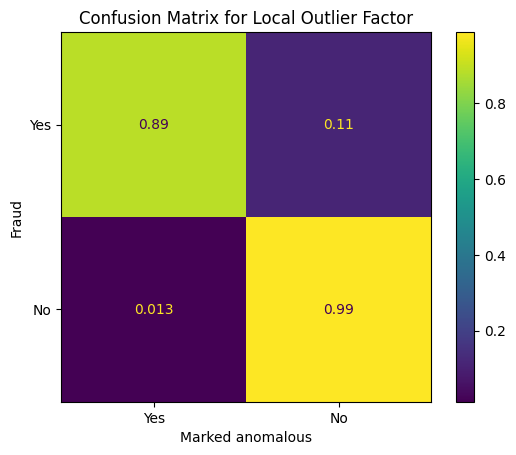

In [212]:
ifr_CM = ConfusionMatrixDisplay.from_predictions(train_classes, ifr_preds, normalize='true')

ifr_CM.ax_.set_xlabel("Marked anomalous")
ifr_CM.ax_.set_ylabel("Fraud")
ifr_CM.ax_.set_xticklabels(["Yes", "No"])
ifr_CM.ax_.set_yticklabels(["Yes", "No"])
ifr_CM.ax_.set_title("Confusion Matrix for Local Outlier Factor")



In [213]:
X_val_IFR = X_val.drop(labels=['lof_nov_score'], axis=1)
X_test_IFR = X_test.drop(labels=['lof_nov_score'], axis=1)

X_train['ifr_score'] = ifr.score_samples(X_IFR) * -1
X_val['ifr_score'] = ifr.score_samples(X_val_IFR) * -1
X_test['ifr_score'] = ifr.score_samples(X_test_IFR) * -1

In [214]:
X_train['ifr_score'].describe()

count    331083.000000
mean          0.421845
std           0.027532
min           0.374561
25%           0.402079
50%           0.416866
75%           0.435640
max           0.667121
Name: ifr_score, dtype: float64

In [215]:
X_val['ifr_score'].describe()

count    82771.000000
mean         0.421992
std          0.027656
min          0.374674
25%          0.402031
50%          0.417045
75%          0.435931
max          0.671830
Name: ifr_score, dtype: float64

In [216]:
X_test['ifr_score'].describe()

count    103464.000000
mean          0.422210
std           0.027708
min           0.374487
25%           0.402229
50%           0.417170
75%           0.436096
max           0.667088
Name: ifr_score, dtype: float64

#### 6.3 Feature Scaling

In [217]:
X_train.columns

Index(['city_pop', 'amt', 'age', 'gender', 'hour', 'category_entertainment',
       'category_entertainment', 'category_food_dining',
       'category_food_dining', 'category_gas_transport',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_net', 'category_grocery_pos', 'category_grocery_pos',
       'category_health_fitness', 'category_health_fitness', 'category_home',
       'category_home', 'category_kids_pets', 'category_kids_pets',
       'category_misc_net', 'category_misc_net', 'category_misc_pos',
       'category_misc_pos', 'category_personal_care', 'category_personal_care',
       'category_shopping_net', 'category_shopping_net',
       'category_shopping_pos', 'category_shopping_pos', 'category_travel',
       'category_travel', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday', 'transaction_zone', 'hotspot_distance',
       'lof_nov_score', 'ifr_score'],
      dtype='object')

In [218]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Delete unneeded data to free up RAM

In [219]:
del X_IFR, X_new, X_normal, Xn_np, X_outliers, X_test_IFR, X_val_IFR, Xa_test_scaled, Xa_test, Xa_train, Xa_train_scaled, Xa_val, Xa_val_scaled, class_normal, data, data_legit, geo_test, geo_train, geo_val, ifr_preds, normal_index, outliers_mask, test_closest, test_distances, train_classes, train_closest, train_distances, train_distances_df, val_closest, val_distances, val_distances_df

### 7. Baseline Model

In [220]:
y_central = np.full(y_train.shape, y_train.mode())

In [221]:
train_perf = y_train
valid_perf = y_val
test_perf = y_val

In [222]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, recall_score, f1_score, fbeta_score, precision_score

In [223]:
print(classification_report(train_perf, y_central))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    330630
           1       0.00      0.00      0.00       453

    accuracy                           1.00    331083
   macro avg       0.50      0.50      0.50    331083
weighted avg       1.00      1.00      1.00    331083



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


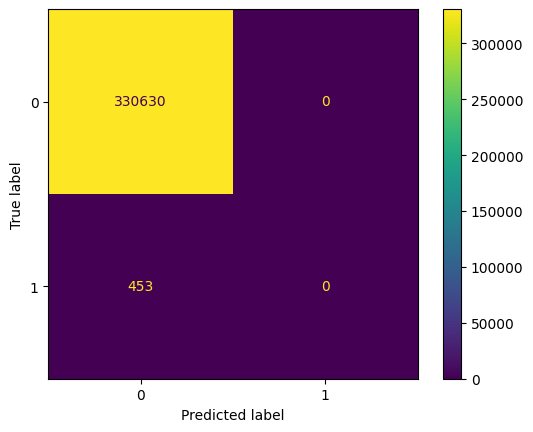

In [224]:
ConfusionMatrixDisplay.from_predictions(train_perf, y_central)

### 8. Train Machine Learning Model

In [225]:
# defining preferences for ConfusionMatrixDisplay

def configure_CM(cm_display, title):
  cm_display.ax_.set_xlabel("Predicted Fraud")
  cm_display.ax_.set_ylabel("Actual Fraud")
  cm_display.ax_.set_xticklabels(["Yes", "No"])
  cm_display.ax_.set_yticklabels(["Yes", "No"])
  cm_display.ax_.set_title(title)

In [228]:
from sklearn.linear_model import LogisticRegression


logit_balanced = LogisticRegression(
    penalty='l2',
    C=1.0,
    class_weight='balanced',
    random_state=40,
    max_iter=250
)

Training

              precision    recall  f1-score   support

           0       1.00      0.97      0.99    330630
           1       0.05      0.94      0.09       453

    accuracy                           0.97    331083
   macro avg       0.52      0.96      0.54    331083
weighted avg       1.00      0.97      0.99    331083



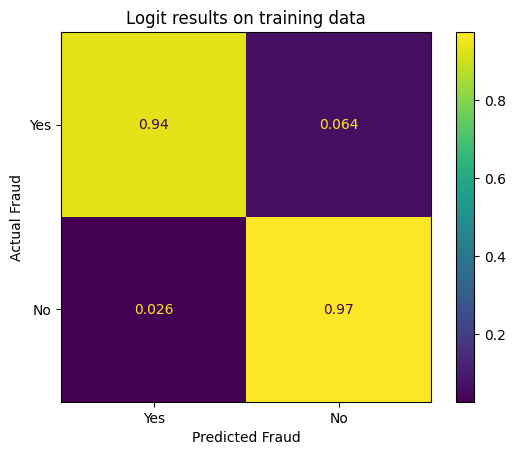

In [232]:
logit_balanced.fit(X_train, y_train)
preds_logit_balanced_train = logit_balanced.predict(X_train)

print(classification_report(y_train, preds_logit_balanced_train))

train_CM = ConfusionMatrixDisplay.from_predictions(y_train, preds_logit_balanced_train, labels=[1, 0], display_labels=['Fraud', 'Not Fraud'], normalize='true')
configure_CM(train_CM, "Logit results on training data")

Validation

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     82658
           1       0.05      0.95      0.09       113

    accuracy                           0.97     82771
   macro avg       0.52      0.96      0.54     82771
weighted avg       1.00      0.97      0.99     82771




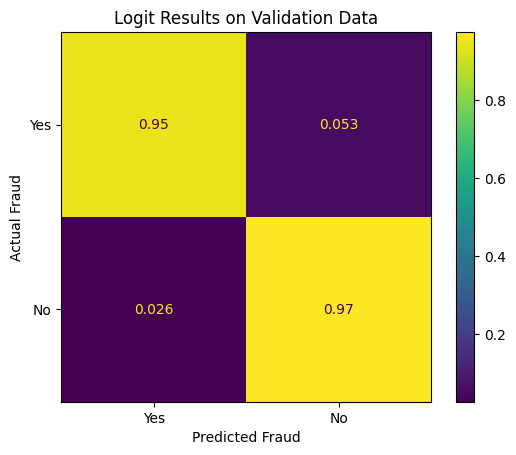

In [233]:
preds_logit_balanced_val = logit_balanced.predict(X_val)

print(classification_report(y_val, preds_logit_balanced_val))
print("")
val_CM = ConfusionMatrixDisplay.from_predictions(y_val, preds_logit_balanced_val, labels=[1, 0], normalize='true')
configure_CM(val_CM, "Logit Results on Validation Data")

### 9. Assess Model Performance

Testing logit_balanced

              precision    recall  f1-score   support

           0       1.00      0.97      0.99    103323
           1       0.05      0.95      0.09       141

    accuracy                           0.97    103464
   macro avg       0.52      0.96      0.54    103464
weighted avg       1.00      0.97      0.99    103464




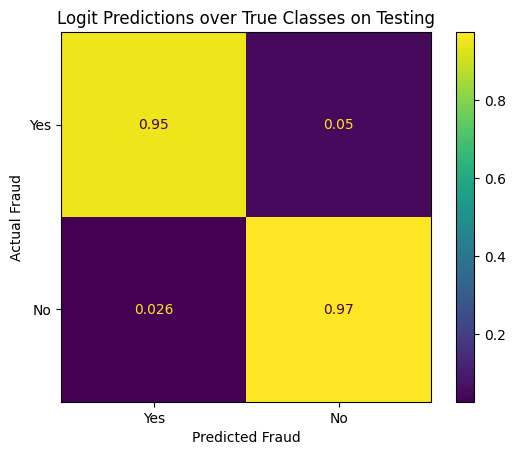

In [234]:
preds_lr_test = logit_balanced.predict(X_test)

print(classification_report(y_test, preds_lr_test))
print("")
CM_logit_balanced = ConfusionMatrixDisplay.from_predictions(y_test, preds_lr_test, labels=[1, 0], display_labels=['Fraud', 'Not Fraud'], normalize='true')
configure_CM(CM_logit_balanced, "Logit Predictions over True Classes on Testing")

In [235]:
confusion_matrix(y_test, preds_lr_test)

array([[100591,   2732],
       [     7,    134]])

Normalized over predictions

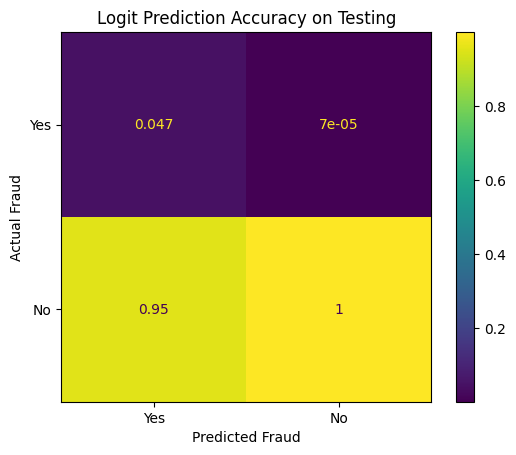

In [236]:
CM_logit_balanced_pred = ConfusionMatrixDisplay.from_predictions(y_test, preds_lr_test, labels=[1, 0],  normalize='pred')
configure_CM(CM_logit_balanced_pred, "Logit Prediction Accuracy on Testing")

Raw numbers

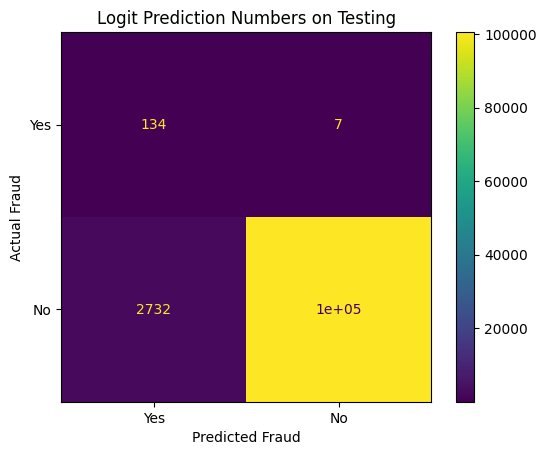

In [237]:
CM_logit_balanced_raw = ConfusionMatrixDisplay.from_predictions(y_test, preds_lr_test, labels=[1, 0])
configure_CM(CM_logit_balanced_raw, "Logit Prediction Numbers on Testing")

In [264]:
len(y_test)

103464

Analysis

In [254]:
coefs = np.array(logit_balanced.coef_).ravel()
features = np.array(X_train.columns)

coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient Weight': coefs
})

coef_df.sort_values('Coefficient Weight', ascending=False, inplace=True)

coef_df

,Feature,Coefficient Weight
4,hour,1.474274
1,amt,0.688998
40,transaction_zone,0.280662
38,Tuesday,0.224533
13,category_grocery_pos,0.208204
14,category_grocery_pos,0.208204
34,Monday,0.196164
27,category_shopping_net,0.186571
28,category_shopping_net,0.186571
33,Friday,0.165251
